# ContactTracing tutorial

This pipeline uses annotated and filtered single-cell data, as well as a database of ligand/receptors, to find detect putative interactions in which:
- the ligand is differentially expressed in one cell type between two conditions
- the expression of the receptor produces an 'interaction effect', characterized by a condition-specific transcriptional response to receptor expression

To start, you need to set these variables in the following code block:
- `anndata_file`: path to h5ad file containing the anndata object with scRNA-seq data
    - The object should have a layer called 'logX' with log-normalized counts
        - We normalize each cell to sum to 10000, then log transform with: np.log10(X + 0.1) - np.log10(0.1). (It is assumed this normalization is already done)
    - It should have a column .obs['cell type'] with clean cell type annotations (mis-annotated cells may produce spurious results)
    - It should have a columns .obs['sample'] with sample name
    - It should have a column .obs['condition'] with condition, we need two conditions to compare (other cells will be ignored). The condition names should be simple (characters should be alphanumeric, underscore, or period, should start with alphabetic character).
    - The index of the .var matrix should map to gene names used in the interactions file
    - The data set should be filtered for quality cells only with confident cell type annotations, high mitochondrial rate removed, likely doublets removed, etc
- `interactions_file`: text file (tab-delimited) with list of ligands and receptors, should have columns with header 'ligand' and 'receptor' giving ligand/receptor pairs. An example file for mouse can be found in the file `data/interactions_mm10.txt` directory of this tutorial.
- The name of two conditions to compare (`condition1` and `condition2`), tests will compare condition1 vs condition2, so that logFC will be positive when condition1 is up.


__Anndata files used for "Cancer cell non-autonomous tumor progression from chromosomal instability" (Li, Hubisz, Earlie et al) can be found here: 10.5281/zenodo.8061222__

In [2]:
## Set input , conditions, and output directories
anndata_file = '../../CellPhoneDB/all_cells_merged_bi_assignments.h5ad'
interactions_file='data/interactions_mm10.txt'

# this should be location of tutorial files/scripts
tutorial_dir='./'

# set output directory
output_dir='../CT_Sarcoma167_S410_subset_tumor'

# tmp_output_dir for unimportant/intermediate output
tmp_output_dir=f'{output_dir}/tmp/NOBACKUP'
!mkdir -p {tmp_output_dir}

In [3]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import itertools
import subprocess
import multiprocessing
from multiprocessing import Pool, freeze_support
from functools import partial
from itertools import product
from kneed import KneeLocator
from adjustText import adjust_text
import statsmodels
import sys
import warnings
from sklearn.preprocessing import scale
from IPython.display import Image

In [4]:
sys.path.append(f'{tutorial_dir}/python')

In [5]:
import contactTracing_library as ct

# we use a couple functions from palantir source code
import palantir_functions as palantirFuncs

In [6]:
# this is just for debugging, if any changes are made to ContactTracing_library.py, reload
importlib.reload(ct)

<module 'contactTracing_library' from '/home/ubuntu/CompiledData/PostNumbatAnalysis/ContactTracing/ContactTracingFinal/.//python/contactTracing_library.py'>

In [7]:
# It seems to be much faster running R with these environment Variables set, surprisingly, turning off multithreading improves runtime more than 2 fold.
Rcommand='MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R'

## Load data

In [8]:
adata = sc.read(anndata_file)

# make sure these fields are empty
adata.obs.index.name=None
adata.var.index.name=None

adata

AnnData object with n_obs × n_vars = 75716 × 35091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'patient', 'celltype_initial_singleR', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'old.ident', 'celltype_', 'celltype_singleR', 'immune', 'Tcell', 'has_cnv_chr1', 'has_loss_chr1', 'has_dupli_chr1', 'proportion_cnv_chr1', 'proportion_loss_chr1', 'proportion_dupli_chr1', 'proportion_scaled_cnv_chr1', 'proportion_scaled_loss_chr1', 'proportion_scaled_dupli_chr1', 'has_cnv_chr2', 'has_loss_chr2', 'has_dupli_chr2', 'proportion_cnv_chr2', 'proportion_loss_chr2', 'proportion_dupli_chr2', 'proportion_scaled_cnv_chr2', 'proportion_scaled_loss_chr2', 'proportion_scaled_dupli_chr2', 'has_cnv_chr3', 'has_loss_chr3', 'has_dupli_chr3', 'proportion_cnv_chr3', 'proportion_loss_chr3', 'proportion_dupli_chr3', 'proportion_scaled_cnv_chr3', 'proportion_scaled_loss_chr3', 'proportion_scaled_dupli_chr3', 'has_cnv

__Make sure cell barcodes are unique__

In [9]:
numdup = sum(adata.obs.index.duplicated())
print(f'{numdup} duplicated barcodes')
if numdup > 0:
    adata.obs_names_make_unique()
    numdup = sum(adata.obs.index.duplicated())
    print(f'now {numdup} duplicated barcodes')

0 duplicated barcodes


## Fix condition and cell type names, set condition1 and condition2

Make sure condition and cell types do not contain any special characters. The code below replaces spaces and slashes with underscores, and removes pound signs. Other strange characters may cause problems, I recommend replacing anything besides alphanumerics and underscores.

In [10]:
adata.obs['orig.ident'].value_counts()
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps',
       'percent.rpl', 'percent.rp', 'patient', 'celltype_initial_singleR',
       'predicted_doublets',
       ...
       'top_dupli_9', 'top_dupli_10', 'proportion_scaled_cnv_avg',
       'proportion_scaled_cnv_sum', 'proportion_cnv_avg', 'proportion_cnv_sum',
       'has_cnv_avg', 'has_cnv_sum', 'integrated_snn_res.0.8',
       'BI_broad_assignments_v2'],
      dtype='object', length=244)

In [11]:
adata.obs['orig.ident'] = [x.replace(' ', '_').replace('/', '_').replace('#', '') for x in adata.obs['orig.ident'].astype(str)]
adata.obs['orig.ident'].value_counts()


SarcomaS408GEX    17415
Sarcoma167GEX     12751
SarcomaS914GEX    12544
Sarcoma708GEX     12366
Sarcoma322GEX     11371
Sarcoma559GEX      7092
SarcomaS410GEX     1745
SarcomaS956GEX      432
Name: orig.ident, dtype: int64

In [12]:
# set condition1 and condition2 .  All tests will be done in the form: condition1 vs condition2. 
# So log2FC will be positive when condition1 expressed higher than condition2

condition1 = 'Sarcoma167GEX'
condition2 = 'SarcomaS410GEX'

In [13]:
keepData = (adata.obs['orig.ident'] == condition1) | (adata.obs['orig.ident'] == condition2)
print(f'Removing {sum(~keepData)} cells with condition != ({condition1} or {condition2})')
adata = adata[keepData]

Removing 61220 cells with condition != (Sarcoma167GEX or SarcomaS410GEX)


In [14]:
adata.obs['BI_broad_assignments_v2'] = [x.replace(' ', '_').replace('/', '_').replace('#', '') for x in adata.obs['BI_broad_assignments_v2'].astype(str)]
adata.obs['BI_broad_assignments_v2'].value_counts()

/tmp/ipykernel_9507/2741157385.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['BI_broad_assignments_v2'] = [x.replace(' ', '_').replace('/', '_').replace('#', '') for x in adata.obs['BI_broad_assignments_v2'].astype(str)]
/home/ubuntu/anaconda3/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


Malignant             7707
Myeloid               4370
T-cell                1686
Endothelial_cell       278
Fibroblast             254
B-cell_Plasma_cell     201
Name: BI_broad_assignments_v2, dtype: int64

In [14]:
adata.X

<14496x35091 sparse matrix of type '<class 'numpy.float32'>'
	with 29508492 stored elements in Compressed Sparse Row format>

In [15]:
cellTypes = adata.obs['BI_broad_assignments_v2'].unique()
adata.layers['logX'] = adata.X.toarray()

adata.obs["cell type"] = adata.obs["BI_broad_assignments_v2"]
adata.obs["condition"] = adata.obs["orig.ident"]

In [16]:
adata.var

,features
MIR1302-2HG,MIR1302-2HG
AL627309.1,AL627309.1
AL627309.2,AL627309.2
AL627309.5,AL627309.5
AP006222.2,AP006222.2
...,...
TFDP3,TFDP3
AL589987.2,AL589987.2
AL713923.1,AL713923.1
AF274573.1,AF274573.1


In [17]:
adata.X = adata.X

__Compute cngeneson, covariate used for MAST__

Represents the scaled number of expressed genes in each cell

In [18]:
adata.obs['cngeneson'] = scale(np.sum(adata.X > 0, axis=1))

__Read interactions file__

In [15]:
interactions = pd.read_csv(interactions_file, sep='\t')
interactions
interactions = interactions.apply(lambda x: x.str.upper())
target_stats = pd.read_csv("sarcoma_target_strats.csv")

__Should not have any duplicated interactions; if so, remove__

In [20]:
f = interactions[['ligand', 'receptor']].duplicated()
if sum(f) > 0:
    print(f'Removing {sum(f)} duplicated interactions')
    interactions = interactions.loc[~f]

__Remove any interactions that don't have both genes in adata__

In [21]:
allgenes = list(set(adata.var.index))
f = interactions['ligand'].isin(allgenes) & (interactions['receptor'].isin(allgenes))
print(f'Removing {sum(~f)} interactions that do not have both genes in adata')
interactions = interactions.loc[f]

Removing 16 interactions that do not have both genes in adata


## Find ligands that are differentially expressed in each cell type

In [22]:
mast_outdir=f'{output_dir}/MAST_between_conditions'
!mkdir -p {mast_outdir}

In [23]:
tumor_specific_labels = pd.read_csv(
    "../../../data/sarcoma_all/Sarcoma167_S410_tumor_clustered_labeled_metadata.csv").set_index("Unnamed: 0")
tumor_specific_labels.index = [item.replace('_2', '_6') for item in tumor_specific_labels.index]
tumor_specific_labels["cancer_types"] = ['Malignant_' + item for item in tumor_specific_labels["cancer_types"] ]
tumor_specific_labels
len(set(adata.obs.index) & set(tumor_specific_labels.index))
adata.obs.loc[tumor_specific_labels.index, 'BI_broad_assignments_v2'] = tumor_specific_labels['cancer_types']
adata.obs.loc[tumor_specific_labels.index, 'cell type'] = tumor_specific_labels['cancer_types']
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rps,percent.rpl,percent.rp,patient,celltype_initial_singleR,predicted_doublets,...,proportion_scaled_cnv_sum,proportion_cnv_avg,proportion_cnv_sum,has_cnv_avg,has_cnv_sum,integrated_snn_res.0.8,BI_broad_assignments_v2,cell type,condition,cngeneson
GATTCAGAGCCGATTT-1_1,Sarcoma167GEX,39853.0,7432,0.634833,0.102878,0.055203,0.158081,Sarcoma167GEX,Pericytes,0,...,7.257226,0.524618,11.541592,0.909091,20.0,4,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.338086
ATCGAGTGTGCTTCTC-1_1,Sarcoma167GEX,39700.0,6956,2.204030,0.098237,0.118388,0.216625,Sarcoma167GEX,Smooth muscle,0,...,8.237344,0.603541,13.277908,0.954545,21.0,27,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.043642
CTAGAGTGTTCCCGAG-1_1,Sarcoma167GEX,39610.0,7439,1.524867,0.053017,0.035345,0.088362,Sarcoma167GEX,Smooth muscle,0,...,8.237344,0.603541,13.277908,0.954545,21.0,4,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.342416
TCTGAGACAATCCAAC-1_1,Sarcoma167GEX,39277.0,7151,0.045828,0.099295,0.040736,0.140031,Sarcoma167GEX,Pericytes,0,...,7.257226,0.524618,11.541592,0.909091,20.0,27,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.164265
GCATGATAGTGACTCT-1_1,Sarcoma167GEX,39329.0,7417,0.742455,0.058481,0.020341,0.078822,Sarcoma167GEX,Smooth muscle,0,...,7.257226,0.524618,11.541592,0.909091,20.0,26,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.328807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGCTTCCACTTACGA-1_6,SarcomaS410GEX,637.0,500,0.313972,0.156986,0.156986,0.313972,SarcomaS410GEX,Pericytes,0,...,7.151895,0.531571,11.694563,1.000000,22.0,6,Malignant_resistant_clones,Malignant_resistant_clones,SarcomaS410GEX,-0.949910
CTGTTTAAGCAATATG-1_6,SarcomaS410GEX,607.0,485,0.164745,0.000000,0.000000,0.000000,SarcomaS410GEX,Macrophages,0,...,1.477858,0.236298,5.198564,0.772727,17.0,12,Myeloid,Myeloid,SarcomaS410GEX,-0.959189
CGTGTCTGTCCGTGAC-1_6,SarcomaS410GEX,616.0,476,2.922078,0.162338,0.162338,0.324675,SarcomaS410GEX,Pericytes,0,...,1.477858,0.236298,5.198564,0.772727,17.0,0,Fibroblast,Fibroblast,SarcomaS410GEX,-0.964756
TACTTGTAGGTGATTA-1_6,SarcomaS410GEX,609.0,505,0.164204,0.000000,0.000000,0.000000,SarcomaS410GEX,Macrophages,0,...,1.477858,0.236298,5.198564,0.772727,17.0,12,Myeloid,Myeloid,SarcomaS410GEX,-0.946817


In [24]:
# set this list to all interesting ligand cell types
ligand_cellTypes = list(adata.obs['BI_broad_assignments_v2'].unique())
ligand_cellTypes

['Malignant_responsive_clones',
 'Malignant_resistant_clones',
 'Endothelial_cell',
 'Myeloid',
 'B-cell_Plasma_cell',
 'Fibroblast',
 'T-cell']

__Run MAST on each cell type, comparing the two conditions__

Note: cngeneson is a recommended covariate in this analysis.

You can add other covariates to the analysis by adding them to the --covariates option, as a comma-delimited list. For example, to add sample name, for example, use the argument: --covariates cngeneson,sample. This requires adata.obs['sample'] ato be defined. Note, it will not make sense for sample to be a covariate unless individual samples are represented in both conditions.

You may also want to modify --numcore option to reflect how many cores you want MAST to use in each run

In [25]:
ligands = list(interactions['ligand'].unique())


In [26]:
## Each command will take several minutes (or more, depending on data set size).
## Set this value to False if you prefer to copy commands to a script and run outside the notebook.
runCommands=True

In [27]:
adata.obs["cell type"] = adata.obs["BI_broad_assignments_v2"]

adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rps,percent.rpl,percent.rp,patient,celltype_initial_singleR,predicted_doublets,...,proportion_scaled_cnv_sum,proportion_cnv_avg,proportion_cnv_sum,has_cnv_avg,has_cnv_sum,integrated_snn_res.0.8,BI_broad_assignments_v2,cell type,condition,cngeneson
GATTCAGAGCCGATTT-1_1,Sarcoma167GEX,39853.0,7432,0.634833,0.102878,0.055203,0.158081,Sarcoma167GEX,Pericytes,0,...,7.257226,0.524618,11.541592,0.909091,20.0,4,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.338086
ATCGAGTGTGCTTCTC-1_1,Sarcoma167GEX,39700.0,6956,2.204030,0.098237,0.118388,0.216625,Sarcoma167GEX,Smooth muscle,0,...,8.237344,0.603541,13.277908,0.954545,21.0,27,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.043642
CTAGAGTGTTCCCGAG-1_1,Sarcoma167GEX,39610.0,7439,1.524867,0.053017,0.035345,0.088362,Sarcoma167GEX,Smooth muscle,0,...,8.237344,0.603541,13.277908,0.954545,21.0,4,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.342416
TCTGAGACAATCCAAC-1_1,Sarcoma167GEX,39277.0,7151,0.045828,0.099295,0.040736,0.140031,Sarcoma167GEX,Pericytes,0,...,7.257226,0.524618,11.541592,0.909091,20.0,27,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.164265
GCATGATAGTGACTCT-1_1,Sarcoma167GEX,39329.0,7417,0.742455,0.058481,0.020341,0.078822,Sarcoma167GEX,Smooth muscle,0,...,7.257226,0.524618,11.541592,0.909091,20.0,26,Malignant_responsive_clones,Malignant_responsive_clones,Sarcoma167GEX,3.328807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGCTTCCACTTACGA-1_6,SarcomaS410GEX,637.0,500,0.313972,0.156986,0.156986,0.313972,SarcomaS410GEX,Pericytes,0,...,7.151895,0.531571,11.694563,1.000000,22.0,6,Malignant_resistant_clones,Malignant_resistant_clones,SarcomaS410GEX,-0.949910
CTGTTTAAGCAATATG-1_6,SarcomaS410GEX,607.0,485,0.164745,0.000000,0.000000,0.000000,SarcomaS410GEX,Macrophages,0,...,1.477858,0.236298,5.198564,0.772727,17.0,12,Myeloid,Myeloid,SarcomaS410GEX,-0.959189
CGTGTCTGTCCGTGAC-1_6,SarcomaS410GEX,616.0,476,2.922078,0.162338,0.162338,0.324675,SarcomaS410GEX,Pericytes,0,...,1.477858,0.236298,5.198564,0.772727,17.0,0,Fibroblast,Fibroblast,SarcomaS410GEX,-0.964756
TACTTGTAGGTGATTA-1_6,SarcomaS410GEX,609.0,505,0.164204,0.000000,0.000000,0.000000,SarcomaS410GEX,Macrophages,0,...,1.477858,0.236298,5.198564,0.772727,17.0,12,Myeloid,Myeloid,SarcomaS410GEX,-0.946817


In [28]:
list(adata.obs.columns)

adata.obs = adata.obs[['orig.ident',
 'nCount_RNA',
 'nFeature_RNA',
 'percent.mt',
 'percent.rps',
 'percent.rpl',
 'percent.rp',
 'cell type',
 'condition',
 'patient',
 'celltype_initial_singleR',
 'predicted_doublets',
 'doublet_scores',
 'RNA_snn_res.0.8',
 'seurat_clusters',
 'old.ident',
 'celltype_',
 'celltype_singleR',
 'immune',
 'Tcell', 
 'has_cnv_avg',
 'has_cnv_sum',
 'integrated_snn_res.0.8',
 'BI_broad_assignments_v2',
 'cngeneson']]
adata.obs['condition'] = adata.obs['orig.ident']
del adata.raw

/tmp/ipykernel_1596/2397651470.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['condition'] = adata.obs['orig.ident']


In [29]:
for cellType in ligand_cellTypes:
    outdir=f'{mast_outdir}/{cellType}'
    !mkdir -p {outdir}
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_ligands.h5ad'
    tmp = adata[adata.obs['cell type'] == cellType, ligands].copy()
    tmp.write(mast_infile)
    # note: add --force option here if you want to overwrite previous results and re-run
    cmd=f'{Rcommand} --vanilla --args --infile "{mast_infile}" --outdir "{mast_outdir}/{cellType}" --groups "condition"'
    cmd += f' --covariates cngeneson --numcore 10 --comp-groups {condition1} {condition2}'
    cmd += f' < {tutorial_dir}/R/MAST_wrapper.R'
    if runCommands:
        # Note: if force is false, will not run if stdoutfile exists already 
        # if wait is false, will run commands in background and return to notebook. 
        #    In this case you may want to decrease --numcore in command above, or else server 
        #    could get overwhelmed if there are many cell types
        ct.run_in_background(cmd, stdoutfile=f'{outdir}/stdout.txt', quiet=True, wait=True, force=True)
    else:
        print(f'{cmd} &> {outdir}/stdout.txt')

calling bash -c 'MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Malignant_responsive_clones_ligands.h5ad" --outdir "../CT_Sarcoma167_S410_subset_tumor/MAST_between_conditions/Malignant_responsive_clones" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups Sarcoma167GEX SarcomaS410GEX < .//R/MAST_wrapper.R' > ../CT_Sarcoma167_S410_subset_tumor/MAST_between_conditions/Malignant_responsive_clones/stdout.txt 2>&1

calling bash -c 'MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R --vanilla --args --infile "../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Malignant_resistant_clones_ligands.h5ad" --outdir "../CT_Sarcoma167_S410_subset_tumor/MAST_between_conditions/Malignant_resistant_clones" --groups "condition" --covariates cngeneson --numcore 10 --comp-groups Sarcoma167GEX SarcomaS410GEX < .//R/MAST_wrapper.R' > ../CT_Sarcoma167_S410_subset_tumor/MAST_between_co

In [30]:
tmp.var

,features
APP,APP
ADORA1,ADORA1
ADORA2A,ADORA2A
ADORA2B,ADORA2B
ADORA3,ADORA3
...,...
PYY,PYY
PPY,PPY
QRFP,QRFP
RLN1,RLN1


In [31]:
# when MAST commands finished, load results and find DE ligands
# (This code also deletes the temporary adata files)
resultlist = []
for cellType in ligand_cellTypes:
    infile = f'{mast_outdir}/{cellType}/{condition1}_vs_{condition2}.csv'
    if not os.path.exists(infile):
        print(f'{cellType} not done yet')
        continue
    print(f'Removing {tmp_output_dir}/adata_{cellType}_ligands.h5ad')
    os.system(f'rm -f {tmp_output_dir}/adata_{cellType}_ligands.h5ad')
    tmp = ct.read_mast_results(infile)
    tmp['gene'] = tmp.index
    tmp['cell type'] = cellType
    tmp = tmp.loc[[x for x in tmp.index if x in ligands]]
    resultlist.append(tmp)
ligandsDE = pd.concat(resultlist, ignore_index=True)
ligandsDE

Removing ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Malignant_responsive_clones_ligands.h5ad
Reading ../CT_Sarcoma167_S410_subset_tumor/MAST_between_conditions/Malignant_responsive_clones/Sarcoma167GEX_vs_SarcomaS410GEX.csv
Removing ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Malignant_resistant_clones_ligands.h5ad
Reading ../CT_Sarcoma167_S410_subset_tumor/MAST_between_conditions/Malignant_resistant_clones/Sarcoma167GEX_vs_SarcomaS410GEX.csv
Removing ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Endothelial_cell_ligands.h5ad
Reading ../CT_Sarcoma167_S410_subset_tumor/MAST_between_conditions/Endothelial_cell/Sarcoma167GEX_vs_SarcomaS410GEX.csv
Removing ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Myeloid_ligands.h5ad
Reading ../CT_Sarcoma167_S410_subset_tumor/MAST_between_conditions/Myeloid/Sarcoma167GEX_vs_SarcomaS410GEX.csv
Removing ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_B-cell_Plasma_cell_ligands.h5ad
Reading ../CT_Sarcoma167_S410

,p,log2FC,ci.hi,ci.lo,fdr,bonferroni,rank_score,FC,scaled_rank_score,abs_scaled_rank_score,gene,cell type
0,1.283748e-260,0.560739,0.604761,0.516718,4.125111e-259,6.187667e-258,2572.084730,1.475025,1442.269160,1442.269160,COL3A1,Malignant_responsive_clones
1,1.543677e-212,0.679998,0.726691,0.633306,3.916064e-211,7.440522e-210,2091.283966,1.602138,1422.069789,1422.069789,SEMA5A,Malignant_responsive_clones
2,1.932490e-207,0.546065,0.565916,0.526213,4.657300e-206,9.314600e-205,2040.308358,1.460097,1114.140114,1114.140114,JAG1,Malignant_responsive_clones
3,1.631039e-163,0.640489,0.674165,0.606813,2.456753e-162,7.861609e-161,1601.044886,1.558858,1025.452046,1025.452046,SLIT2,Malignant_responsive_clones
4,1.246623e-97,0.462409,0.495830,0.428988,1.178181e-96,6.008725e-95,942.212177,1.377840,435.686974,435.686974,LAMA2,Malignant_responsive_clones
...,...,...,...,...,...,...,...,...,...,...,...,...
1381,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,TNFSF18,T-cell
1382,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,VEGFD,T-cell
1383,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,WNT11,T-cell
1384,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,WNT2,T-cell


Text(0, 0.5, 'min adjusted p-value')

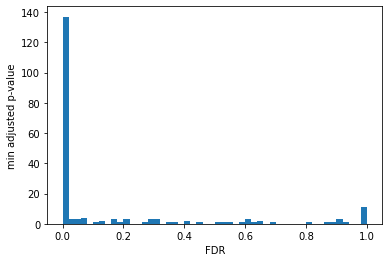

In [32]:
# compute minimum FDR for each ligand across all cell types
minLigandFDR = ligandsDE[['gene', 'fdr']].groupby('gene').min()
plt.hist(minLigandFDR['fdr'], bins=50)
plt.xlabel('FDR')
plt.ylabel('min adjusted p-value')

In [33]:
sigLigands = list(minLigandFDR.loc[minLigandFDR['fdr'] < 0.05].index)
print(f'{len(sigLigands)} out of {len(ligands)} are significantly DE')

142 out of 432 are significantly DE


In [34]:
keepInteractions = interactions['ligand'].isin(sigLigands)
print(f'Keeping {sum(keepInteractions)} out of {interactions.shape[0]} interactions')

Keeping 340 out of 964 interactions


In [35]:
interactions = interactions.loc[keepInteractions]

In [36]:
cellTypes

array(['Malignant', 'Endothelial_cell', 'Myeloid', 'B-cell_Plasma_cell',
       'Fibroblast', 'T-cell'], dtype=object)

ycol: fdr
Wrote ../CT_Sarcoma167_S410_subset_tumor/MAST_between_conditions/figures/Sarcoma167GEX_vs_SarcomaS410GEX_Endothelial_cell.png


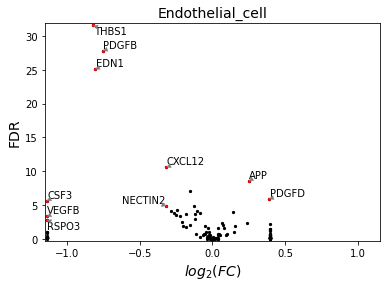

In [37]:
# example plot of MAST results for one cell type
cellType=cellTypes[1]
# note: this function can take awhile if max_num_label is big
ct.make_volcano_plot(ligandsDE.loc[ligandsDE['cell type'] == cellType], title=cellType, ycol='fdr', label_col='gene',
                     fontsize=10, ylabel='FDR', max_num_label=10,
                     plot_outfile=f'{mast_outdir}/figures/{condition1}_vs_{condition2}_{cellType}.png')

## Run interaction test on receptors associated with DE ligands

This is computationally quite expensive, it can take many minutes per receptor, per cell type. Run-time and memory usage increases with the number of cells. If you use too many cores you may run out of memory and jobs will crash. Some ways to reduce runtime, which are implemented in this notebook, include:
- Only run on cell types / receptors of interest
- Only run on receptors with expression levels above some threshold
- Only run on receptors associated with DE ligands
- Assess interaction effect only in HVGs rather than across genes

In [38]:
# List of cell types that you want to assess interaction effect in
# not necessarily all cell types are of interest

adata.obs['sample'] = adata.obs['orig.ident']
adata.obs['cell type'] = adata.obs['BI_broad_assignments_v2']
receptor_cellTypes = list(set(adata.obs['cell type']))

/tmp/ipykernel_1596/259615015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['sample'] = adata.obs['orig.ident']
/tmp/ipykernel_1596/259615015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell type'] = adata.obs['BI_broad_assignments_v2']


In [39]:
# receptors to run on; alternatively, set this to a list of interesting receptors
interaction_receptors = list(interactions['receptor'].unique())
print(f'Num receptors = {len(interaction_receptors)}')

Num receptors = 171


In [40]:
# use this if not reducing to hvgs
keepGenes=list(adata.var.index)

In [41]:
len(keepGenes)

35091

### To test only on HVGs, reduce to HVGs

To test all genes (as done in CIN-TME paper), skip this section. But reducing to HVGs provides substantial computational speedup.

/tmp/ipykernel_1596/4242035529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['sample'] = adata.obs['orig.ident']
/home/ubuntu/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/ubuntu/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

Found 4307 highly variable genes


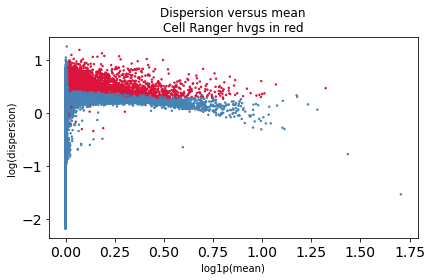

In [42]:
# This code computes HVGs, if they are not already annotated. Other methods are also possible

# This is inverse function to get original adata.layers['X'], if necessary
adata.layers['X'] = 10.0**(adata.layers['logX'] + np.log10(0.1)) - 0.1
adata.obs['sample'] = adata.obs['orig.ident']
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='sample', n_bins=20, max_mean=np.inf, layer='X')
boolean_to_color = {True:'crimson',False:'steelblue'}
colors_cell_ranger = [boolean_to_color[True] if x >0 else boolean_to_color[False]
                      for x in adata.var['highly_variable']]
plt.scatter(np.log1p(adata.var['means']), np.log(adata.var['dispersions']),
            s=2, c=colors_cell_ranger)
plt.xlabel('log1p(mean)')
plt.ylabel('log(dispersion)')
plt.title('Dispersion versus mean\nCell Ranger hvgs in red')
print(f'Found {sum(adata.var["highly_variable"])} highly variable genes')
fn = output_dir + '/hvgs_scanpy_cellranger_20bins_nomax.png'
plt.tight_layout()
plt.savefig(fn, dpi=400)
plt.show()
plt.close()

In [43]:
keepGenes = list(adata.var.loc[adata.var['highly_variable']].index)
len(keepGenes)

4307

In [44]:
targets = list(set(interactions['receptor']).union(set(interactions['ligand'])))

In [45]:
# a few ligands/receptors may not be highly variable but we need to keep them as well
print(f'Keeping {len(keepGenes)} HVGs as well as {len(set(targets).difference(set(keepGenes)))} ligands/receptors that are not HVGs')
keepGenes = list(set(targets).union(set(keepGenes)))

Keeping 4307 HVGs as well as 143 ligands/receptors that are not HVGs


### Run interaction tests

This is the slowest part of the analysis, this section could take many days, depending on number of receptors/ cell types and size of data set, and the computational resource (# of CPUs and memory available).

The commands will be written to a script, and the script executed outside the notebook using GNU parallel

In [46]:
# split adata by cellType, compute fraction of cells expressing each gene per cell type, and write adata object to file
# do for all cell types (not just receptor) because will use later
all_fracExp = []
adata_cellTypes = {}
del adata.raw
for cellType in adata.obs['cell type'].unique():

    adata_cellTypes[cellType] = adata[adata.obs['cell type'] == cellType, keepGenes].copy()
    adata_cellTypes[cellType].var['fracExp'] = np.transpose(np.sum(adata_cellTypes[cellType].layers['logX'] > 0, axis=0)/adata_cellTypes[cellType].shape[0])
    if cellType in receptor_cellTypes:
        
        all_fracExp += list(adata_cellTypes[cellType].var.loc[interaction_receptors, 'fracExp'])
        
        adata_cellTypes[cellType].write(f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad')

__Choose cutoff for receptor expression__

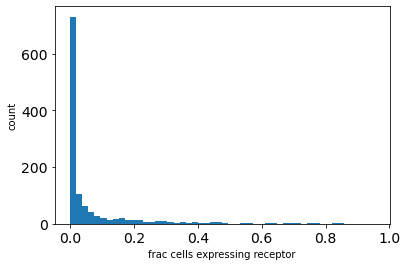

In [47]:
# look at distribution of fraction cells expressing receptors; may use this to choose cutoff for fracExp
plt.hist(all_fracExp, bins=50)
plt.xlabel('frac cells expressing receptor')
plt.ylabel('count')
plt.show()

In [48]:
fracExp_cutoff = 0.05

In [49]:
for cellType in receptor_cellTypes:
    skipping = adata_cellTypes[cellType].var.loc[interaction_receptors,'fracExp'] < fracExp_cutoff
    print(f'{cellType}: Skipping {sum(skipping)} receptors with fracExp < {fracExp_cutoff:0.2f}, {sum(~skipping)} receptors remaining')

Malignant_responsive_clones: Skipping 98 receptors with fracExp < 0.05, 73 receptors remaining
Fibroblast: Skipping 120 receptors with fracExp < 0.05, 51 receptors remaining
Myeloid: Skipping 129 receptors with fracExp < 0.05, 42 receptors remaining
T-cell: Skipping 147 receptors with fracExp < 0.05, 24 receptors remaining
Endothelial_cell: Skipping 111 receptors with fracExp < 0.05, 60 receptors remaining
B-cell_Plasma_cell: Skipping 149 receptors with fracExp < 0.05, 22 receptors remaining
Malignant_resistant_clones: Skipping 128 receptors with fracExp < 0.05, 43 receptors remaining


In [50]:
interaction_outdir=f'{output_dir}/interaction_test'
!mkdir -p {interaction_outdir}

__Write commands to run.__

Additional covariates can be added to the analysis here in the same way as the ligand analyis 

As in the MAST analysis of ligands, covariates can be added to the command below, by adding any column of anndata's .obs matrix to the `--covariates` option below. They should be comma-delimited, i.e., to add scrublet score, change to `--covariates cngeneson,scrublet`

We had a reviewer suggest doublet score as a covariate, adding this did not hurt but also didn't change results. It does not seem to increase run-time to add covariates, so any covariate that may influence gene expression levels may be sensible to add, any column in adata.obs can be included (though it should have a name withour spaces or strange characters).  Note that if each sample is from a single condition, then sample is not an appropriate covariate, since the it will be impossible to disentangle the condition effect from the sample effect.

#### Generate command file

In [51]:
force=False
command_file = open(f'{interaction_outdir}/commands.sh', 'w')
expected_files = set()
num_commands=0
for cellType in receptor_cellTypes:
    curr_adata = adata_cellTypes[cellType]
    keep_receptors = curr_adata.var.loc[interaction_receptors,'fracExp'] >= fracExp_cutoff
    genes = list(keep_receptors.loc[keep_receptors].index)

    outdir=f'{interaction_outdir}/{cellType}'
    !mkdir -p {outdir}
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad'
    
    curr_logX = curr_adata.layers['logX']
    fcond1 = np.array(curr_adata.obs['condition'] == condition1)
    fcond2 = np.array(curr_adata.obs['condition'] == condition2)
    for gene in genes:
        output_file = f'{interaction_outdir}/{cellType}/{gene}/interaction_{condition1}_vs_{condition2}.txt'
        
        # check to see if we have data to analyze this gene.
        # we require at least two cells expressing the receptor and two not expressing
        # Additionally, there should be at least one cell expressing and non-expressing for each condition
        geneidx = np.where(curr_adata.var.index == gene)[0]
        fexp = np.array(curr_logX[:,geneidx] > 0).flatten()
        if sum(fexp) < 2:
            continue
        if sum(~fexp) < 2:
            continue
        if (sum(fexp & fcond1) == 0):
            continue
        if (sum(fexp & fcond2)==0):
            continue
        if (sum((~fexp) & fcond1) == 0):
            continue
        if (sum((~fexp) & fcond2) == 0):
            continue
        expected_files.add(output_file)
        if force==False and os.path.exists(output_file):
            continue
        
        cmd=f'mkdir -p {outdir}/{gene} && {Rcommand} --vanilla --args --infile "{mast_infile}" --outdir "{interaction_outdir}/{cellType}"'
        cmd += f' --conditions "{condition1}" "{condition2}"'
        cmd += f' --covariates cngeneson --numcore 1 --genes "{gene}"'
        if force:
            cmd += f' --force'
        cmd += f' < {tutorial_dir}/R/MAST-interactionTest.R &> {outdir}/{gene}/stdout.txt\n'
        command_file.write(cmd)
        num_commands = num_commands+1
command_file.close()
print(f'Wrote command file {interaction_outdir}/commands.sh with {num_commands} commands')

Wrote command file ../CT_Sarcoma167_S410_subset_tumor/interaction_test/commands.sh with 0 commands


In [114]:
# This is total number of interaction tests we need to run
len(expected_files)

287

__Set the jobs running, using parallel command__

In this cell below, `-j 10` specifies the number of simultaneous jobs to run. Each job uses a single core (as indicated by the --numcore 1 option used above; the MAST run can be parallelized, but most efficient is to run each job on a single core, and run many jobs simultaneously).

I recommend first executing the following cell with '-j 1' (one job only) and then using 'top' in a terminal to determine how much memory the job uses. Then, depending on how many cores and how much memory is available on your machine, you can kill the job (using code below, under the comment HERE IS CODE TO KILL ALL JOBS). Then restart with a number of jobs that your machine can handle.

For example, if one job takes 10 Gb of memory, and your machine has 256 Gb memory available, you should be able to use -j 25, or maybe -j 24 to leave some wiggle room. However, if your machine only has 10 cores, then you will need to use -j 10.

Note that the amount of memory required is proportional to both the number of cells in the data set, and the number of genes being analyzed. So if there are multiple cell types in receptor_cellTypes (each with a different number of cells), you should test the memory usage on a job from the biggest cell type. Or, you can split the jobs up by cell type, and use different levels of parallelization depending on the memory requirements for each.

In [115]:
ct.run_in_background(f'parallel -j 10 < {interaction_outdir}/commands.sh', 
                     stdoutfile=f'{interaction_outdir}/commands_stdout.txt')

calling bash -c 'parallel -j 10 < ../CT_Sarcoma167_S410_subset_tumor/interaction_test/commands.sh' > ../CT_Sarcoma167_S410_subset_tumor/interaction_test/commands_stdout.txt 2>&1 &



Once jobs have started, you can use the command below to check how many have finished.

In [52]:
# check progress of jobs.
numdone=0
for f in expected_files:
    if os.path.exists(f):
        numdone=numdone+1
print(f'Done {numdone} out of {len(expected_files)} interaction tests')

Done 287 out of 287 interaction tests


It is recommend to run 'top' on the server to see how memory and CPU usage is doing.

If you are overrunning resources, some jobs may crash and need to be restarted, or you may need to kill all processes (using the code block below). If your jobs don't all finish on the first pass, you can go back up to the 'Generate command file' cell above, make sure to set `force=False`, and it will generate a new commands file containing only the jobs that haven't completed yet. You can then repeat this process until all jobs have finished.

In [53]:
# HERE IS CODE TO KILL ALL JOBS, in case you are overrunning memory or something
# (Note this will kill any R job or parallel command running, but only within the docker container)
subprocess.run(["killall", "parallel"])
subprocess.run(["killall", "/usr/local/lib/R/bin/exec/R"])

parallel: no process found
/usr/local/lib/R/bin/exec/R: No such file or directory


CompletedProcess(args=['killall', '/usr/local/lib/R/bin/exec/R'], returncode=1)

__When all jobs finished, you may clean up temporary adata files__

In [54]:
for cellType in receptor_cellTypes:
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad'
    mast_infile_2 = f'{tmp_output_dir}/adata_{cellType}_inttest.mtx'

    print(f'Deleting {mast_infile}')
    os.system('rm -f {mast_infile}')
    print(f'Deleting {mast_infile_2}')

    os.system('rm -f {mast_infile_2}')

Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Malignant_responsive_clones_inttest.h5ad
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Malignant_responsive_clones_inttest.mtx
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Fibroblast_inttest.h5ad
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Fibroblast_inttest.mtx
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Myeloid_inttest.h5ad
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Myeloid_inttest.mtx
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_T-cell_inttest.h5ad
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_T-cell_inttest.mtx
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Endothelial_cell_inttest.h5ad
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_Endothelial_cell_inttest.mtx
Deleting ../CT_Sarcoma167_S410_subset_tumor/tmp/NOBACKUP/adata_B-cell_Plasma_cell_inttest.h5ad
Deleting

## Read in interaction test results

Need to wait for all interaction tests to finish before coming to this section

In [55]:
inttest = f'interaction_{condition1}_vs_{condition2}'

In [56]:
# the function is I/O intensive so you may not want to use too many cores
ncore=20
deg = ct.read_all_contactTracing_results(receptor_cellTypes, interaction_receptors, interaction_outdir, 
                                         cond1=condition1, cond2=condition2,
                                         inttest=inttest, ncore=ncore, genes=keepGenes)
deg

Done reading files, 287 found of 1197 combinations. concatenating.
Done


AnnData object with n_obs × n_vars = 287 × 4450
    obs: 'cell type', 'receptor'
    layers: 'coef_Sarcoma167GEX_cluster', 'coef_SarcomaS410GEX', 'coef_cluster', 'pval', 'fdr.i1'

The 'deg' object is an AnnData structure, where each row is a cell_type/receptor combination, 
there is a column for each gene tested for transcriptional response. The layers returned are:
- coef_highCIN_cluster: the logFC applied to cells in the highCIN/receptor_on category. This is the 'interaction_coefficient'
- coef_lowCIN: the logFC applied to cells in the lowCIN categories (receptor on or off)
- coef_cluster: the logFC applied to cells in the receptor_on category (both conditions)
- pval: The p-value describing the significance of the interaction coefficient
- fdr.i1: FDR-corrected p-value. FDR correction is done independently across each row.

In [57]:
deg.write_h5ad("read_all_ct.h5ad")

In [58]:
# compute number of significant interactions for each row
deg.obs['numSigI1_fdr05'] = np.sum(deg.layers['fdr.i1'] < 0.05, axis=1)

In [59]:
deg.obs

,cell type,receptor,numSigI1_fdr05
0,Malignant_responsive_clones,SORL1,9
1,Malignant_responsive_clones,TNFRSF21,155
2,Malignant_responsive_clones,ENTPD1,10
3,Malignant_responsive_clones,NCAM1,289
4,Malignant_responsive_clones,PTPRS,186
...,...,...,...
282,Malignant_resistant_clones,SFRP1,0
283,Malignant_resistant_clones,ROR1,0
284,Malignant_resistant_clones,ROR2,0
285,Malignant_resistant_clones,PLXNA4,0


## Generate a ranked list of interactions

This is one possibly way to rank interactions - of all the interactions with a differentially expressed ligand, rank by size of interaction effect (numSigI1_fdr05)

In [68]:
ligands = ligandsDE[['gene', 'cell type', 'log2FC', 'fdr']].rename(columns={'gene':'ligand',
                                                                           'cell type':'cell_type_ligand'})

In [69]:
# some ligands have log2FC=NA but they are not significant (check)
ligands.loc[pd.isna(ligands['log2FC']),'fdr'].unique()

array([1.])

In [70]:
# they all have FDR of 1 so just set log2FC to 0
ligands.loc[pd.isna(ligands['log2FC']),'log2FC'] = 0

In [71]:
ligands['ligandDE'] = ligands['fdr'] < 0.05

In [72]:
receptors = deg.obs.rename(columns={'cell type':'cell_type_receptor'})

In [73]:
ranked_interactions = interactions.merge(ligands, on='ligand').merge(receptors, on='receptor').sort_values(
    by=['ligandDE', 'numSigI1_fdr05'], ascending=False)[['ligand', 'cell_type_ligand', 'receptor', 'cell_type_receptor',
                                                         'log2FC', 'fdr', 'ligandDE', 'numSigI1_fdr05']].rename(
    columns={'log2FC':'log2FC_ligand', 'fdr':'fdr_ligand', 'numSigI1_fdr05':'numSigI1_fdr05_receptor'})
ranked_interactions.to_csv(f'{output_dir}/ranked_interactions.txt', index=False, sep='\t')
print(f'Wrote ranked interaction list to {output_dir}/ranked_interactions.txt')

Wrote ranked interaction list to ../CT_Sarcoma167_S410_subset_tumor/ranked_interactions.txt


In [74]:
# Here are top 5
ranked_interactions.iloc[:5]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
3640,EDN1,Malignant_responsive_clones,EDNRA,Malignant_responsive_clones,-0.004226,2.142527e-04,True,1065
3643,EDN1,Malignant_resistant_clones,EDNRA,Malignant_responsive_clones,-0.082922,7.226710e-05,True,1065
3646,EDN1,Endothelial_cell,EDNRA,Malignant_responsive_clones,-0.806652,7.884888e-26,True,1065
3658,EDN1,T-cell,EDNRA,Malignant_responsive_clones,-1.086748,3.480060e-07,True,1065
700,DKK2,Malignant_responsive_clones,LRP6,Malignant_responsive_clones,0.023918,8.037988e-04,True,686


You can also make a list of ranked interactions integrated over ligand cell type, for example, require ligand DE in one cell type

Here, the values of ligand cell type, log2FC, and fdr are all for the ligand cell type with minimum fdr value

In [75]:
ranked_interactions2 = ranked_interactions.loc[ranked_interactions.drop(columns='cell_type_ligand').groupby(
    ['ligand', 'receptor', 'cell_type_receptor']).idxmin()['fdr_ligand']].sort_values(
    by=['ligandDE', 'numSigI1_fdr05_receptor'], ascending=False)
ranked_interactions2.to_csv(f'{output_dir}/ranked_interactions_across_ligand_cell_type.txt', index=False, sep='\t')
print('Wrote ranked interaction list (integrated over ligand cell type) to {output_dir}/ranked_interactions_across_ligand_cell_type.txt')

KeyError: '[nan] not in index'

In [ ]:
ranked_interactions2.iloc[:5]

## Explore downstream interaction effects

We can use the coef estimates in the deg structure, along with p-values, to explore downstream effects.

### Optional: fix NA coefficients

A substantial number of logFC estimates coming from MAST are recorded as NA, even when the p-value is significant. I believe this is because the MAST estimate is hitting +/- infinity, or passing some internal boundaries set by MAST. In this section we can replace the NAs with a rough estimate based on mean # of expressed cells in different categories.

__First, how many of these NAs are there?__

In [76]:
sig = deg.layers['fdr.i1'] < 1
print(f'Out of {sum(sum(sig))} tests with fdr < 1:')
coef_layers = [x for x in deg.layers.keys() if x.startswith('coef') and not x.endswith('_est')] 
for layer in coef_layers:
    na = np.isnan(deg.layers[layer])
    print(f'  {sum(sum(na & sig))} ({sum(sum(na & sig))/sum(sum(sig))*100:0.2f}%) have {layer}=NA')

Out of 120635 tests with fdr < 1:
  15624 (12.95%) have coef_Sarcoma167GEX_cluster=NA
  309 (0.26%) have coef_SarcomaS410GEX=NA
  712 (0.59%) have coef_cluster=NA


In [77]:
# Here is code that creates the estimates - for each coefficient in deg.layers, it addes another layer with the suffix _est that gives
# the rough estimated values

# Note- it will distribute each row of deg across the cores specified by ncores, in chunks of size chunksize.
# I have found it is much faster to use big chunks.

                

ct.estimate_contactTracing_coefs(deg, adata, condition1, condition2, ncores=10, chunksize=50)

Done 30 out of 287 (10.5%)
Done 59 out of 287 (20.6%)
Done 88 out of 287 (30.7%)
Done 117 out of 287 (40.8%)
Done 146 out of 287 (50.9%)
Done 175 out of 287 (61.0%)
Done 204 out of 287 (71.1%)
Done 233 out of 287 (81.2%)
Done 262 out of 287 (91.3%)


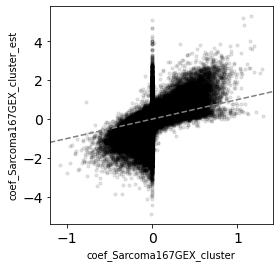

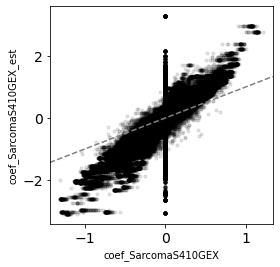

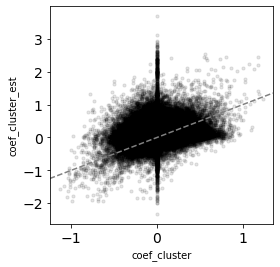

In [78]:
# plot MAST estimates vs rough estimates - they should fall along the diagonal, with a good deal of noise.
# (MAST model is much more sophisticated).
#log_factor = np.log10(2)
for layer in coef_layers:
    if f'{layer}_est' in deg.layers:
        plt.subplots(figsize=(4,4))
        plt.scatter(np.array(deg.layers[layer]).reshape(-1), 
                    np.array(deg.layers[f'{layer}_est']).reshape(-1), color='black', s=10, alpha=0.1)
        plt.gca().axline((1,1), slope=1, ls='--', color='gray')
        plt.xlabel(layer)
        plt.ylabel(f'{layer}_est')
        plt.show()

__If you want to replace NAs with estimated values, do:__

In [79]:
for layer in coef_layers:
    f = np.isnan(deg.layers[layer])
    deg.layers[layer][f] = deg.layers[f'{layer}_est'][f]

In [80]:
# confirm there are no more NAs
sig = deg.layers['fdr.i1'] < 1
print(f'Out of {sum(sum(sig))} tests with fdr < 1:')
for layer in coef_layers:
    na = np.isnan(deg.layers[layer])
    print(f'  {sum(sum(na & sig))} ({sum(sum(na & sig))/sum(sum(sig))*100:0.2f}%) have {layer}=NA')

Out of 120635 tests with fdr < 1:
  0 (0.00%) have coef_Sarcoma167GEX_cluster=NA
  0 (0.00%) have coef_SarcomaS410GEX=NA
  0 (0.00%) have coef_cluster=NA


### Example plot showing interaction effect for single receptor in one cell type


The plot shows the log-fold coefficient for genes when the receptors is on, in each of the two conditions.

The color of the dot shows the size of the 'interaction effect'. The size of the dot shows the significance (-log10 pvalue).

Points falling along the diagonal show the same effect in both conditions, as you move away from the diagonal you can see genes that are affected differently.

Text(0.5, 1.0, 'T-cell CD46')

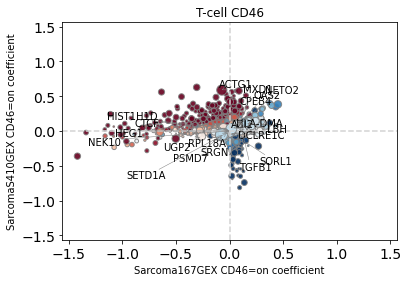

In [81]:
# change next two lines to cellType / gene of interest
cellType = 'T-cell'
gene = 'CD46'
numLabel=20

#cellType='PMN_gMDSC'
#gene='Cd74'

idx = np.where((deg.obs['cell type'] == cellType) & (deg.obs['receptor'] == gene))[0][0]

pvals = deg.layers['pval'][idx,:].reshape(-1)
cond1On = (deg.layers[f'coef_{condition1}_cluster'][idx,:] + deg.layers['coef_cluster'][idx,:]).reshape(-1)
cond2On = (deg.layers[f'coef_{condition2}'][idx,:] + deg.layers['coef_cluster'][idx,:]).reshape(-1)

# color by interaction effect
cvals = deg.layers[f'coef_{condition1}_cluster'][idx,:].reshape(-1)

# size by p-value
svals = -np.log10(pvals)
# 150 just gives reasonable size dot, can adjust as needed
svals = svals * 150/np.max(svals)


nanvals = (np.isnan(cond1On)) | (np.isnan(cond2On))
f = (pvals < 1) & (~nanvals)
if sum(nanvals) > 0:
    print(f'Skipping {sum(nanvals)} points with NAN coefs and p-val < 1, plotting {sum(f)} genes')

order = np.argsort(svals[f])

plt.scatter(cond2On[f][order], cond1On[f][order], 
            #c=-np.log10(sigvals[f]), cmap=plt.cm.Greys, vmin=0, vmax=20, s=svals[f])
            c=cvals[f][order], s=svals[f][order],
            edgecolors=ct.makeTransparent('gray', alpha=0.5),
            cmap=plt.cm.RdBu_r, vmin=-0.3, vmax=0.3, alpha=0.9)


# add text labels to most significant genes
use_numLabel = numLabel
if use_numLabel > sum(f):
    use_numLabel = sum(f)
tmpdf = pd.DataFrame({'xvals':cond2On[f][order],
                      'yvals':cond1On[f][order],
                      'gene':deg.var.index[f][order],
                      's':svals[f][order]}).sort_values(by='s', ascending=False).reset_index(drop=True)

texts = []
for i in tmpdf.iloc[:use_numLabel].index:
    texts.append(plt.text(tmpdf.loc[i,'xvals'], tmpdf.loc[i,'yvals'], tmpdf.loc[i,'gene'], fontsize=10))
niter = adjust_text(texts, 
                    x=list(tmpdf['xvals']), 
                    y=list(tmpdf['yvals']), 
                    #avoid_self=True, force_text=(2,2),
                    #force_pull=(0.001,0.001),
                    expand_points=(1.1, 1.1),
                    expand_text=(1.1,1.1),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
                     
plt.xlabel(f'{condition1} {gene}=on coefficient')
plt.ylabel(f'{condition2} {gene}=on coefficient')
maxval = np.max(np.abs(list(cond2On[f])+list(cond1On[f])))*1.1
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
linelist=[]
linelist += plt.plot([-maxval, maxval], [0,0], c='lightgray', linestyle='dashed')
linelist += plt.plot([0,0], [-maxval, maxval], c='lightgray', linestyle='dashed')
plt.title(cellType + ' ' + gene)


## Run cluster test on all ligands/receptors and compute differential components

This is done in preparation of making the circos plot, we use diffusion components to create an ordering of ligands/receptors around the circle

In the CIN/TME paper, this was the 'cluster' test, run in MAST. But it is very slow to do in MAST and only used for visualization so it makes more sense to use a faster algorithm. Using scanpy here. It still takes awhile, but hopefully minutes to an hour or so, rather than days.

In [82]:
adata

AnnData object with n_obs × n_vars = 14496 × 35091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'cell type', 'condition', 'patient', 'celltype_initial_singleR', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'old.ident', 'celltype_', 'celltype_singleR', 'immune', 'Tcell', 'has_cnv_avg', 'has_cnv_sum', 'integrated_snn_res.0.8', 'BI_broad_assignments_v2', 'cngeneson', 'sample'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: 'X_umap'
    layers: 'logX', 'X'

In [83]:
cellTypes = adata.obs['cell type'].unique()
cellTypes

['Malignant_responsive_clones', 'Malignant_resistant_clones', 'Endothelial_cell', 'Myeloid', 'B-cell_Plasma_cell', 'Fibroblast', 'T-cell']
Categories (7, object): ['B-cell_Plasma_cell', 'Endothelial_cell', 'Fibroblast', 'Malignant_resistant_clones', 'Malignant_responsive_clones', 'Myeloid', 'T-cell']

In [84]:
sig_receptors = deg.obs.loc[deg.obs['numSigI1_fdr05'] > 0]
sig_receptors.shape

(111, 3)

In [85]:
# Create object to hold differential expression results
# It is an anndata structure with rows for every target gene and cell type we are interested in
# and columns for every gene

# The targets we are interested in are receptors with some minimum number of interaction effects,
# and ligands associated with these receptors.

minInteractions=1

receptor_df = deg.obs.loc[deg.obs['numSigI1_fdr05'] >= minInteractions][['cell type', 'receptor']].rename(columns={'receptor':'target'})
ligand_df = pd.DataFrame(product(ligand_cellTypes, 
                                 interactions.loc[interactions['receptor'].isin(receptor_df['target']), 'ligand']),
                         columns=['cell type', 'target'])
targets_df = pd.concat([receptor_df, ligand_df])
targets_df = targets_df[~targets_df.duplicated()].sort_values(by=['cell type', 'target']).reset_index(drop=True)
targets_df.index = targets_df.index.map(str)
diffComp = sc.AnnData(X=np.empty(shape=(targets_df.shape[0], deg.var.shape[0]), dtype=np.float32),
                      obs=targets_df, var=deg.var)
diffComp

AnnData object with n_obs × n_vars = 745 × 4450
    obs: 'cell type', 'target'

In [86]:
# add layers for all the DE statistics
diffComp.layers['pval'] = diffComp.X.copy()
diffComp.layers['fdr'] = diffComp.X.copy()
diffComp.layers['lfc'] = diffComp.X.copy()
diffComp.layers['score'] = diffComp.X.copy()

In [87]:
def de_score(targetCellType):
    (target, cellType) = targetCellType
    adata = adata_cellTypes[cellType]
    idx = np.where(adata.var.index == target)[0]
    isExpressed = adata.layers['logX'][:,idx] > 0
    tmpcol = f'{target}_cluster'
    adata.obs[tmpcol] = pd.Categorical(['expressed' if x else 'not' for x in isExpressed], categories=['expressed', 'not'])
    if (sum(adata.obs[tmpcol].value_counts() <=1) > 0):
        # cannot compute if we don't have more than one cell in both categories...skip
        adata.obs.drop(columns=tmpcol, inplace=True)
        return (target, cellType, 0)
    newkey=f'rank_genes_groups_{target}'
    sc.tl.rank_genes_groups(adata, groupby=tmpcol, layer='logX', method='wilcoxon', groups=['expressed'], key_added=newkey)
    adata.obs.drop(columns=tmpcol, inplace=True)
    tmprg = adata.uns[newkey]
    pvals = np.array([x[0] for x in tmprg['pvals']])
    minPval = np.min(pvals[pvals > 0])
    pvals[pvals==0] = minPval
    scores = np.array([x[0] for x in tmprg['scores']])
    fdr = statsmodels.stats.multitest.multipletests(pvals, method='fdr_bh')[1]
    tmpdf = pd.DataFrame({'gene':[x[0] for x in tmprg['names']],
                          'pval':pvals,
                          'fdr':fdr,
                          'lfc':[x[0] for x in tmprg['logfoldchanges']],
                         'score':scores}).set_index('gene')
    tmpdf['score'] =  -np.log10(tmpdf['pval'])*tmpdf['lfc']
    adata.uns.pop(newkey)
    return (target,cellType,tmpdf)
    #return -np.log10(tmpdf['pval'])*tmpdf['lfc']

The following cell loops through all cell types, all ligands/receptors, and performs a test for differential expression across
all genes, for whehter gene expression is related to whether the ligand/receptor is expressed. It is all done
within the given cell type. In the end, `diffComp` is an adta object where:
- each row is a ligand or a receptor in a particular cell type
- each column is a gene (same columns as adata)
- there are matrices .layers['lfc'], .layers['pval'], .layers['fdr'], and .layers['score'] with results from rank_genes_groups function ('wilcoxan' method).

In [88]:
# set this to the number of jobs you want to run simultaneously
num_processes=20
targetlist = [(diffComp.obs.loc[x, 'target'], diffComp.obs.loc[x, 'cell type']) for x in diffComp.obs.index]
numjob=diffComp.shape[0]
numdone=0
fracReport=0.1
nextfrac=0.1
print(f'Running LRT tests for all ligands/receptors')
with multiprocessing.Pool(processes=num_processes) as p:
    func = partial(de_score)
    for tmp in p.imap_unordered(func, targetlist, chunksize=50):
        target = tmp[0]
        cellType=tmp[1]
        idx = np.where((diffComp.obs['target'] == target) & (diffComp.obs['cell type'] == cellType))[0][0]
        if type(tmp[2]) == int:
            diffComp.layers['pval'][idx,:] = 1
            diffComp.layers['fdr'][idx,:] = 1
            diffComp.layers['lfc'][idx,:] = 0
            diffComp.layers['score'][idx,:] = 0
        else:
            for layer in ['pval', 'fdr', 'lfc', 'score']:
                diffComp.layers[layer][idx,:] = np.array(tmp[2].loc[diffComp.var.index, layer]).reshape(-1)
        numdone=numdone+1
        if numdone/numjob > nextfrac:
            print(f'Done {numdone} out of {numjob} LRT tests ({numdone/numjob*100:.1f}% done)')
            nextfrac = nextfrac + fracReport

Running LRT tests for all ligands/receptors
Done 75 out of 745 LRT tests (10.1% done)
Done 150 out of 745 LRT tests (20.1% done)
Done 224 out of 745 LRT tests (30.1% done)
Done 299 out of 745 LRT tests (40.1% done)
Done 373 out of 745 LRT tests (50.1% done)
Done 448 out of 745 LRT tests (60.1% done)
Done 522 out of 745 LRT tests (70.1% done)
Done 596 out of 745 LRT tests (80.0% done)
Done 671 out of 745 LRT tests (90.1% done)
Done 745 out of 745 LRT tests (100.0% done)


__If the code above fails, here is a non-parallelized version to try__

Otherwise skip the following cell

In [89]:
# This cell is optional alternative to previous cell!
numdone=0
fracReport=0.1
nextfrac=0.1
maxidx = diffComp.obs.shape[0]
for idx in range(maxidx):
    cellType = diffComp.obs.iloc[idx]['cell type']
    target = diffComp.obs.iloc[idx]['target']
    tmp = de_score((target, cellType))
    if type(tmp[2]) == int:
        diffComp.layers['pval'][idx,:] = 1
        diffComp.layers['fdr'][idx,:] = 1
        diffComp.layers['lfc'][idx,:] = 0
        diffComp.layers['score'][idx,:] = 0
    else:
        for layer in ['pval', 'fdr', 'lfc', 'score']:
            diffComp.layers[layer][idx,:] = np.array(tmp[2].loc[diffComp.var.index, layer]).reshape(-1)
    numdone=numdone+1
    if numdone/numjob > nextfrac:
        print(f'Done {numdone} out of {numjob} LRT tests ({numdone/numjob*100:.1f}% done)')
        nextfrac = nextfrac + fracReport

Done 75 out of 745 LRT tests (10.1% done)
Done 150 out of 745 LRT tests (20.1% done)
Done 224 out of 745 LRT tests (30.1% done)
Done 299 out of 745 LRT tests (40.1% done)
Done 373 out of 745 LRT tests (50.1% done)
Done 448 out of 745 LRT tests (60.1% done)
Done 522 out of 745 LRT tests (70.1% done)
Done 596 out of 745 LRT tests (80.0% done)
Done 671 out of 745 LRT tests (90.1% done)
Done 745 out of 745 LRT tests (100.0% done)


In [90]:
diffComp.obs['fracExp'] = -1
for i in diffComp.obs.index:
    target = diffComp.obs.loc[i,'target']
    cellType = diffComp.obs.loc[i,'cell type']
    diffComp.obs.loc[i,'fracExp'] = adata_cellTypes[cellType].var.loc[target,'fracExp']

In [91]:
# set score to zero when testing gene for transcriptional response to itself
idx1=0
count=0
for i in diffComp.obs.index:
    target = diffComp.obs.loc[i,'target']
    cellType = diffComp.obs.loc[i,'cell type']
    if target in diffComp.var.index:
        idx2 = np.where(diffComp.var.index == target)[0][0]
        diffComp.layers['score'][idx1,idx2] = 0
        count=count+1
    idx1=idx1+1
print(f'Fixed {count} scores for DE of own gene to zero')

Fixed 745 scores for DE of own gene to zero


In [92]:
# This took awhile to compute, so save:
diffComp.write(f'{output_dir}/diffComp.h5ad')

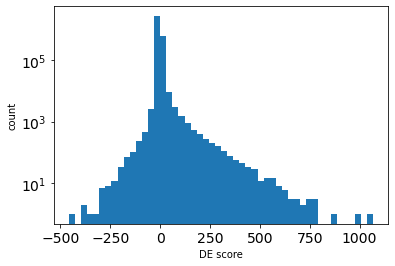

In [93]:
plt.hist(diffComp.layers['score'].reshape(-1), bins=50)
plt.xlabel('DE score')
plt.ylabel('count')
plt.yscale('log')
plt.show()

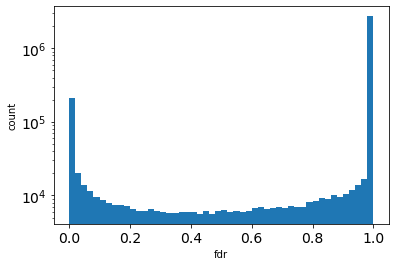

In [94]:
plt.hist(diffComp.layers['fdr'].reshape(-1), bins=50)
plt.xlabel('fdr')
plt.ylabel('count')
plt.yscale('log')
plt.show()

In [95]:
diffComp.layers['score-sig'] = diffComp.layers['score'].copy()
f = diffComp.layers['fdr'] > 0.05
diffComp.layers['score-sig'][f]= 0

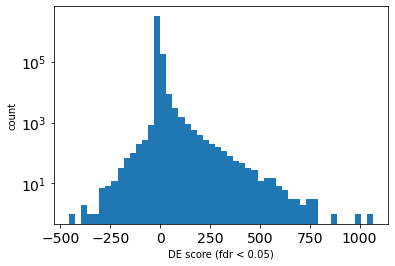

In [96]:
plt.hist(diffComp.layers['score-sig'].reshape(-1), bins=50)
plt.xlabel('DE score (fdr < 0.05)')
plt.ylabel('count')
plt.yscale('log')
plt.show()

### Compute diffusion maps

In [97]:
diffComp

AnnData object with n_obs × n_vars = 745 × 4450
    obs: 'cell type', 'target', 'fracExp'
    layers: 'pval', 'fdr', 'lfc', 'score', 'score-sig'

In [98]:
diffComp.X = diffComp.layers['score']

In [99]:
cellTypes=diffComp.obs['cell type'].value_counts().index
sc.settings.verbosity = 0
diffComp.obs['cell_type_dc1'] = 0
diffComp.obs['cell_type_dc2'] = 0
!mkdir -p {output_dir}/diffusionComponents
for cellType in cellTypes:
    f = diffComp.obs['cell type'] == cellType
    tmp = diffComp[f].copy()
    print(cellType,tmp.shape)
    if(tmp.shape[0] < 5):
        print(f'Skipping {cellType}, only {tmp.shape[0]} rows')
        continue
    init_npcs = np.min([50, tmp.shape[0]-2])
    sc.pp.pca(tmp, n_comps=init_npcs)
    if np.min(tmp.uns['pca']['variance'])==0:
        init_npcs = np.argmin(tmp.uns['pca']['variance'])
        tmp.uns['pca']['variance'] = tmp.uns['pca']['variance'][:init_npcs]
        tmp.uns['pca']['variance_ratio'] = tmp.uns['pca']['variance_ratio'][:init_npcs]
    #sc.pl.pca_variance_ratio(tmp, n_pcs=init_npcs, log=True)
    x = [x for x in range(len(tmp.uns['pca']['variance_ratio']))]
    y = np.log(tmp.uns['pca']['variance_ratio'])
    knee = KneeLocator(x=x, y=y, curve='convex', direction='decreasing', online=True, interp_method='polynomial')
    #knee.plot_knee_normalized()

    opt_n_pcs = knee.knee+1
    print('Optimal Number of PCs: ', str(opt_n_pcs))
    sc.pp.pca(tmp, n_comps=opt_n_pcs)
    #dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(tmp.obsm['X_pca']), n_components=15)
    #ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=15)
    dm_res = palantirFuncs.run_diffusion_maps(pd.DataFrame(tmp.obsm['X_pca']), n_components=15)
    ms_data = palantirFuncs.determine_multiscale_space(dm_res, n_eigs=15)
    tmp.obsm['DC'] = ms_data.to_numpy()
    diffComp.obs.loc[f,'cell_type_dc1'] = tmp.obsm['DC'][:,0]
    diffComp.obs.loc[f,'cell_type_dc2'] = tmp.obsm['DC'][:,1]
    
    # get a version normalized by cell type for circos plots
    maxval = np.max(np.abs(tmp.obsm['DC'][:,0]))
    if maxval == 0:
        maxval = 1
    diffComp.obs.loc[f,'cell_type_dc1_norm'] = tmp.obsm['DC'][:,0]/maxval

Malignant_responsive_clones (151, 4450)
Optimal Number of PCs:  8
Determing nearest neighbor graph...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


T-cell (110, 4450)
Optimal Number of PCs:  7
Determing nearest neighbor graph...
Malignant_resistant_clones (104, 4450)
Optimal Number of PCs:  10
Determing nearest neighbor graph...
Myeloid (101, 4450)
Optimal Number of PCs:  38
Determing nearest neighbor graph...
Endothelial_cell (95, 4450)
Optimal Number of PCs:  12
Determing nearest neighbor graph...
B-cell_Plasma_cell (92, 4450)
Optimal Number of PCs:  8
Determing nearest neighbor graph...
Fibroblast (92, 4450)
Optimal Number of PCs:  8
Determing nearest neighbor graph...


__DC plots__

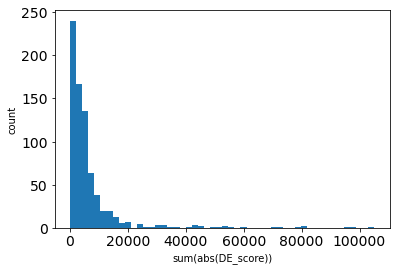

In [100]:
# size each receptor/ligand by sum of abs(DE scores) across all genes
diffComp.obs['absDE'] = np.sum(np.abs(diffComp.layers['score']), axis=1)
plt.hist(diffComp.obs['absDE'], bins=50)
plt.xlabel('sum(abs(DE_score))')
plt.ylabel('count')
diffComp.obs['absDE_scaled'] = diffComp.obs['absDE']/np.max(diffComp.obs['absDE'])

Malignant_responsive_clones (151, 4450)


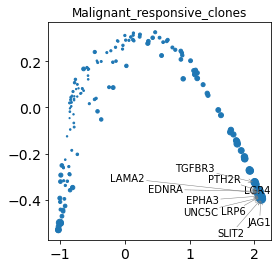

T-cell (110, 4450)


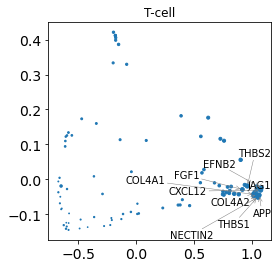

Malignant_resistant_clones (104, 4450)


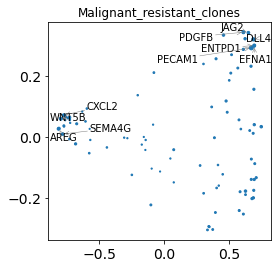

Myeloid (101, 4450)


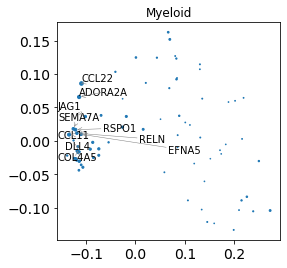

Endothelial_cell (95, 4450)


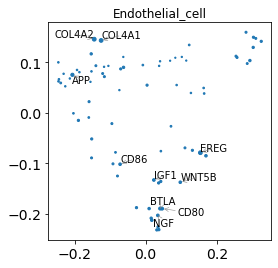

B-cell_Plasma_cell (92, 4450)


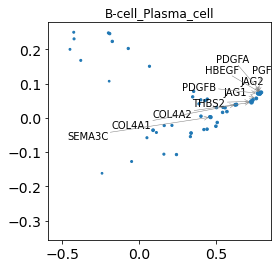

Fibroblast (92, 4450)


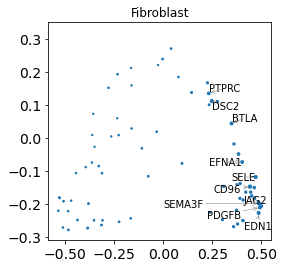

In [101]:
sc.settings.verbosity = 0
numLabel=10
sizeFactor=100  # adjust to scale poinst
for cellType in cellTypes:
    f = diffComp.obs['cell type'] == cellType
    tmp = diffComp[f].copy()
    print(cellType,tmp.shape)
    if(tmp.shape[0] < numLabel):
        continue
    plt.subplots(figsize=(4,4))
    
    xvals = np.array(tmp.obs['cell_type_dc1'])
    yvals = np.array(tmp.obs['cell_type_dc2'])
    sizevals = np.array(tmp.obs['absDE_scaled']*sizeFactor)
    labels = np.array(tmp.obs['target'])
    plt.scatter(xvals, yvals, s=sizevals)
    plt.title(cellType)
    
    texts = []
    tmpobs = tmp.obs.sort_values(by='absDE_scaled', ascending=False).iloc[:numLabel]
    for i in tmpobs.index:
        texts.append(plt.text(tmpobs.loc[i,'cell_type_dc1'], tmpobs.loc[i,'cell_type_dc2'], tmpobs.loc[i,'target'],
                             fontsize=10))
    f = list(range(0, len(x), 50))
    niter = adjust_text(texts, 
                        x=xvals, y=yvals, 
                        #avoid_self=True, force_text=(2,2),
                        #force_pull=(0.001,0.001),
                        expand_points=(0.1,0.1),
                        expand_text=(1.1,1.1),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
                     
    
    plt.savefig(f'{output_dir}/diffusionComponents/diffusion_components_{cellType}.png', dpi=300, bbox_inches='tight')
    plt.show()

### GSEA analysis of DCs

GSEA analysis may yield some insight about biological processes underlying the diffusion components.

A GMT file is required, they may be specialized for each cell type, the ones we use are in the tutorial data directory.

__First, for each gene and each cell type, compute the correlation between DC1 and the DE Scores,
we will use this correlation as a score to feed GSEA__

In [102]:
for cellType in diffComp.obs['cell type'].unique():
    f = (diffComp.obs['cell type'] == cellType)
    print(cellType, sum(f), sum(diffComp.obs['cell type'] == cellType))
    dc = diffComp.obs.loc[f,'cell_type_dc1']
    corrCol = f'{cellType}_dc1_corr'
    for g in diffComp.var.index:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            diffComp.var.loc[g,corrCol] = np.corrcoef(dc.to_numpy(), diffComp[f,g].X.flatten())[0,1]

B-cell_Plasma_cell 92 92
Endothelial_cell 95 95
Fibroblast 92 92
Malignant_resistant_clones 104 104
Malignant_responsive_clones 151 151
Myeloid 101 101
T-cell 110 110


__Also, in our case, the data is from mouse but GMT files use human genes. We need a mapping from mouse to human gene names.__

Our GSEA code will use this mapping, plus the capitalized version of any mouse gene that does not appear in this mapping, if the capitalized version appears in the human gene set.

## Circos plot

First, make a data frame containing all relevant statistics about ligands and receptors
including numSigInt_fdr05 for receptors, ligand fdr and logFC, and diffusion component values (for sorting them along circle)

This should be filtered to only the ligands/receptors that should be plotted along circle

In [112]:
# combine data about ligands and receptors into one data frame

# Only keep receptors with a minimum number of interaction effects (numSigI1_fdr05 > 0)
# and ligands that interact with these receptors, and are differentially expressed (fdr < 0.05)

# a 'target' refers to a ligand or receptor, some can be both. The columns 'ligand' and 'receptor' are booleans
# set to True if the target is a ligand/receptor
degobs = deg.obs.loc[deg.obs['numSigI1_fdr05'] > 0]
target_stats = diffComp.obs.merge(degobs.rename(columns={'receptor':'target'}), on=['target', 'cell type'],how='outer')
target_stats['receptor'] = ~pd.isna(target_stats['numSigI1_fdr05'])
allReceptors = list(set(target_stats.loc[target_stats['receptor'], 'target']))
allLigands = list(set(interactions.loc[interactions['receptor'].isin(allReceptors),'ligand']))
target_stats['ligand'] = target_stats['target'].isin(allLigands)

target_stats = target_stats.merge(ligandsDE[['gene', 'cell type', 'log2FC', 'fdr']].rename(columns={'gene':'target'}), 
                                  on=['target', 'cell type'], how='left')

# remove ligands that are not DE
f = (target_stats['ligand']) & (target_stats['fdr'] >= 0.05)
f1 = (f) & (target_stats['receptor'])
target_stats.loc[f1,'ligand'] = False
f2 = (f) & (~target_stats['receptor'])
target_stats = target_stats.loc[~f2].reset_index(drop=True)

f = pd.isna(target_stats['numSigI1_fdr05'])
target_stats.loc[f,'numSigI1_fdr05'] = 0


In [113]:
target_stats

,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,B-cell_Plasma_cell,THBS1,0.114428,0.110343,-0.042751,0.139567,4287.700195,0.040778,0.0,False,True,-0.704831,7.559795e-03
1,Endothelial_cell,ANXA1,0.449640,-0.152761,0.082233,-0.469861,2568.872559,0.024431,0.0,False,True,-0.182457,1.639741e-02
2,Endothelial_cell,APP,0.823741,-0.206367,0.075416,-0.634744,10704.587891,0.101806,0.0,False,True,0.250264,3.102982e-09
3,Endothelial_cell,CADM1,0.043165,-0.152062,-0.051889,-0.467712,5143.027344,0.048913,0.0,False,True,0.393479,5.866459e-03
4,Endothelial_cell,COL4A1,0.989209,-0.125548,0.143646,-0.386161,14500.186523,0.137904,0.0,False,True,-0.119777,1.945633e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,T-cell,TNFRSF14,0.066429,-0.276972,-0.133317,-0.256529,1114.658936,0.010601,121.0,True,False,NaN,NaN
320,T-cell,TNFRSF1B,0.147687,-0.214098,-0.110322,-0.198295,1042.713867,0.009917,40.0,True,False,NaN,NaN
321,T-cell,VEGFA,0.004745,0.846250,-0.041025,0.783788,12860.233398,0.122307,0.0,False,True,-1.086748,2.808414e-06
322,T-cell,WNT5A,0.004152,0.885608,-0.042455,0.820241,12384.000000,0.117778,0.0,False,True,-0.115610,1.732708e-02


In [114]:
set(target_stats["cell type"])

{'B-cell_Plasma_cell',
 'Endothelial_cell',
 'Fibroblast',
 'Malignant_resistant_clones',
 'Malignant_responsive_clones',
 'Myeloid',
 'T-cell'}

In [115]:
# Show counts of ligands, receptors, some genes are both
target_stats[['ligand', 'receptor']].value_counts()

ligand  receptor
True    False       213
False   True        102
True    True          9
dtype: int64

In [19]:
cellType_colormap = {'B-cell_Plasma_cell': '#F9D318',
     'Endothelial_cell': '#6B0C0C',
     'Fibroblast': '#216C04',
     'Malignant': '#0047CF',
     'Myeloid': '#A16E0F',
     'T-cell': '#EA0C0C'}

__This example shows only interactions where ligand is from PMN_gMDSC and receptor from Tumor cells or Macrophages__

There are also filters for numSigI1_fdr05 >= in receptor, abs(log2FC) > 0.12 in ligand, and abs(fdr) < 0.05 in ligand

__This example shows all interactions (with at least numSigI1_fdr05 >= 12 in receptor, ligand abs(logFC) > 0.12 and ligand(fdr) < 0.05)__

In [20]:
CM_DIVERGING = plt.cm.RdBu_r
import csv
import matplotlib
def hexcolor_to_circos(col, alpha=1):
    """Convert hex color string to circos-formatted string
    :param color: i.e., "#F9D318"
    :param alpha: transparency from 0-1 (0 = fully transparent)
    :return: string like "249,211,24,0.5"
    """
    if alpha is None:
        return(','.join(str(int(y*255)) for y in matplotlib.colors.to_rgb(col)))
    return(','.join(str(int(y*255)) for y in matplotlib.colors.to_rgb(col)) + ','+str(alpha))

def rgb_to_hex(rgb):
    """Convert rgb tuple to hex format
    :param rgb: a 3-tuple like (1,0,0)
    :return: A hex like "#FF0000"
    """
    return '#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def cm_to_circos(vals, vmin, vmax, colormap=CM_DIVERGING, alpha=1):
    """Convert numeric array to list of circos-formatted colors
    :param vals: array/list of values
    :param vmin: minimum value on color scale
    :param vmax: maximum value on color scale
    :param colormap: matplotlib colormap to use
    :param alpha: transparency parameter (0-1)
    :return: a list of color strings to used in circos plot
    """
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    co = mapper.to_rgba(vals)
    if alpha is None:
        return [f'{int(x[0]*255)},{int(x[1]*255)},{int(x[2]*255)}' for x in co]    
    return [f'{int(x[0]*255)},{int(x[1]*255)},{int(x[2]*255)},{alpha}' for x in co]

def cm_to_color(val, vmin, vmax, colormap=CM_DIVERGING, alpha=1):
    """Convert numeric value to color based on colormap
    :param val: single numeric value
    :param vmin: minimum value on color scale
    :param vmax: maximum value on color scale
    :param colormap: matplotlib colormap to use
    :alpha: transparency parameter (0-1)
    :return: a 4-tuple color (r,g,b,a), all values between 0-1
    """
    x = cm_to_circos([val], vmin, vmax, colormap, alpha)[0].split(',')
    return((int(x[0])/255, int(x[1])/255,int(x[2])/255,float(x[3])))

def makeTransparent(color, alpha):
    """Add transparency to a color string
    :param color: A string representing a color (i.e., "gray" or "#FF0000")
    :param alpha: Transparency value (0-1)
    :return: A 4-tuple color (r,g,b,a), all values between 0-1
    """
    val = matplotlib.colors.to_rgba(color)
    return((val[0], val[1], val[2], alpha))

def __make_circos_conf_file(outdir, target_stats, heatmap_plots, histogram_plots,
                            cellType_order=[], cellType_labels=True, label_size=40,
                            label_parallel='yes'):

    f = open(f'{outdir}/circos.conf', 'w')
    cellTypes = target_stats['cell type'].unique()
    celltype_list=[]
    for c in cellType_order:
        if c in cellTypes:
            celltype_list.append(c)
    for c in cellTypes:
        if c not in cellType_order:
            celltype_list.append(c)
    celltype_list = [x.replace(' ', '_').replace('/','_').replace('\n', '_').lower() for x in celltype_list]

    f.write('karyotype = karyotype.txt\n')
    f.write('chromosomes_order = ' + ','.join(celltype_list) + '\n')
    f.write('<ideogram>\n')
    f.write('<spacing>\n')
    f.write('  default = 5u\n')
    f.write('  break = 5u\n')
    f.write('  axis_break = yes\n')
    f.write('  axis_break_style = 2\n')
    f.write('  axis_break_at_edge = no\n')
    f.write('  <break_style 1>\n')
    f.write('      stroke_color = black\n')
    f.write('      fill_color = blue\n')
    f.write('      thickness = 0.25r\n')
    f.write('      stroke_thickness = 2\n')
    f.write('  </break_style>\n')
    f.write('  <break_style 2>\n')
    f.write('      stroke_color = black\n')
    f.write('      thickness = 1.5r\n')
    f.write('      stroke_thickness = 3\n')
    f.write('  </break_style>\n')
    f.write('</spacing>\n\n')

    f.write('radius = 0.7r\n')
    f.write('thickness = 0.04r\n')
    f.write('fill = yes\n')
    f.write('stroke_color = dgrey\n')
    f.write('stroke_thickness = 5p\n')
    if cellType_labels:
        f.write('show_label = yes\n')
    else:
        f.write('show_label = no\n')
    f.write('label_font = default\n')
    f.write('label_radius = 1.05r\n')
    f.write(f'label_size = {label_size}\n')
    f.write(f'label_parallel = {label_parallel}\n')
    f.write('label_with_tag = no\n')
    f.write('label_format = eval(replace(replace(var(label), "ligand", "\\nligand"), " receptor", "\\nreceptor"))\n')
    f.write('label_center = yes\n')
    f.write('</ideogram>\n\n')
    f.write('<plots>\n')
    rstart =1
    width=0.05
    
    for p in heatmap_plots:
        f.write('<plot>\n')
        f.write('  show=yes\n')
        f.write('  type = heatmap\n')
        f.write('  file = ' + p + '.txt\n')
        f.write(f'  r1 = {(rstart-0.00001):0.5f}r\n')
        f.write(f'  r0 = {(rstart - width):0.5f}r\n')
        rstart = rstart - width
        minval = np.nanmin(target_stats[p])
        maxval = np.nanmax(target_stats[p])
        f.write(f'  min = {minval}\n')
        f.write(f'  max = {maxval}\n')
        f.write(f'</plot>\n\n')

    width = 0.1
    for p in histogram_plots:
        f.write('<plot>\n')
        f.write('  show=yes\n')
        f.write('  type = histogram\n')
        f.write('  file = ' + p + '.txt\n')
        f.write(f'  r1 = {(rstart-0.00001):0.5f}r\n')
        f.write(f'  r0 = {(rstart - width):0.5f}r\n')
        rstart = rstart - width
        f.write('  fill_color = black\n')
        f.write('  orientation = in\n')
        f.write(f'</plot>\n\n')

    width = 0.3
    f.write('<plot>\n')
    f.write('  show = yes\n')
    f.write('  type = text\n')
    f.write('  file = labels.txt\n')
    f.write(f'  r1 = {rstart:0.5f}r\n')
    f.write(f'  r0 = {(rstart - width):0.5f}r\n')
    rstart = rstart -  width
    f.write('  label_font = default\n')
    f.write('  label_size = 20\n')
    f.write('  show_links = yes\n')
    f.write('  link_dims = 0p,8p,5p,8p,0p\n')
    f.write('  link_thickness = 1p\n')
    f.write('  link_color = gray\n')
    f.write('  padding = 3p\n')
    f.write('  rpadding = 0p\n')
    f.write('  label_snuggle = yes\n')
    f.write('  max_snuggle_distance = 2r\n')
    f.write('  snuggle_sampling = 3\n')
    f.write('  snuggle_tolerance = 0.25r\n')
    f.write('  snuggle_refine = no\n')
    f.write('  snuggle_link_overlap_test = no\n')
    f.write('  snuggle_link_overlap_tolerance = 2p\n')
    f.write('</plot>\n')
    f.write('</plots>\n\n')

    f.write('<links>\n')
    f.write('<link>\n')
    f.write('  show = yes\n')
    f.write('  file = links.txt\n')
    f.write('  color = 0,0,0,0.1\n')
    f.write(f'  radius = {rstart:0.5f}r\n')
    f.write('  ribbon = no\n')
    f.write('  bezier_radius = 0.1r\n')
    f.write('</link>\n')
    f.write('</links>\n\n')
    
    f.write('<image>\n')
    f.write('<<include image.generic.conf>>\n')
    f.write('background = white\n')
    f.write('</image>\n')

    f.write('<<include etc/colors_fonts_patterns.conf>>\n')
    f.write('<<include etc/housekeeping.conf>>\n')

    f.close()
    print(f'Wrote {outdir}/circos.conf')

def plot_v2(interactions,
                     target_stats,
                     outdir,
                     numSigI1_stat='numSigI1_fdr05',
                     ligand_deg_logfc_col='log2FC',
                     ligand_deg_pval_col='fdr',
                     links_min_numSigI1=1,
                     links_max_ligand_fdr=0.05,
                     links_min_ligand_absLog2FC=0,
                     order_col='cell_type_dc1_norm',
                     heatmap_plots=['cell_type_dc1_norm'],
                     histogram_plots=['numSigI1_fdr05'],
                     cellType_order=[],
                     bigGenes=None,
                     bigFontSize=24,
                     max_thickness=25,
                     max_numSigI1=None,
                     boldLigand=True,
                     boldReceptor=False,
                     boldGenes=None,
                     boldCellType=None,
                     log2FC_vmax=0.2,
                     colorMap=None,
                     cellType_labels=True,
                     cellType_filter=None,
                     cellType_filter_receptor=None,
                     cellType_filter_ligand=None,
                     cleanCellTypes=True,
                     title=None,
                     titleSize=60,
                     labelSize=40,
                     labelParallel='yes'):
    target_stats.loc[target_stats['receptor'],'type'] = 'receptor'
    target_stats.loc[target_stats['ligand'],'type'] = 'ligand'
    target_stats['type'] = pd.Categorical(target_stats['type'], categories=['receptor', 'ligand', 'both'])
    target_stats.loc[(target_stats['ligand']) & (target_stats['receptor']),'type'] = 'both'
    f = np.isnan(target_stats[order_col])
    print(f'Removing {sum(f)} rows of target_stats that have {order_col}=NaN')
    target_stats = target_stats.loc[~f]
    degl = target_stats.loc[target_stats['ligand']].copy()
    degr = target_stats.loc[target_stats['receptor']].copy()
    print(f' num_ligand = {degl.shape[0]}')
    print(f' num_receptor = {degr.shape[0]}')
    
    degMetaAll = degr.merge(interactions, left_on='target', right_on='receptor', suffixes=('_receptor', ''), how='left').merge(
        degl, left_on='ligand', right_on='target', suffixes=('', '_ligand'), how='left').drop(
        columns=['receptor_receptor', 'ligand_receptor', 'ligand_ligand', 'receptor_ligand'])
    
    degMetaAll['labeled0'] = (((degMetaAll[f'{ligand_deg_pval_col}_ligand'] < links_max_ligand_fdr) & 
                               (np.abs(degMetaAll[f'{ligand_deg_logfc_col}_ligand']) >= links_min_ligand_absLog2FC)) &
                               ((degMetaAll[numSigI1_stat] >= links_min_numSigI1)))

    # remove cell types that don't have any labeled interactions
    labf = degMetaAll['labeled0']
    allCellTypes = set(target_stats['cell type'])
    if cleanCellTypes:
        keepCellTypes = set(degMetaAll.loc[labf,'cell type']).union(set(degMetaAll.loc[labf,'cell type_ligand']))
    else:
        keepCellTypes = allCellTypes
    removeCellTypes = allCellTypes.difference(keepCellTypes)
    if (len(removeCellTypes) > 0 and cleanCellTypes):
        removeStr=','.join(list(removeCellTypes))
        print(f'Removing {len(removeCellTypes)} cell Types that have no labels: {removeStr}')
    target_stats = target_stats.loc[target_stats['cell type'].isin(list(keepCellTypes))]
    target_stats['chr'] = target_stats['cell type'].astype(str)
    print("target_stats.shape = " + str(target_stats.shape))
    if target_stats.shape[0] == 0:
        return
    allCellTypes = list(set(target_stats['cell type']))
    if colorMap is None:
        colors = iter(plt.cm.tab20(np.linspace(0, 1, len(allCellTypes))))
        colorMap = {}
        for cellType in list(allCellTypes):
            colorMap[cellType] =  rgb_to_hex(next(colors))
    else:
        numMissing=sum([x not in colorMap for x in allCellTypes])
        if numMissing > 0:
            colors = iter(plt.cm.tab20(np.linspace(0, 1, numMissing)))
            for cellType in allCellTypes:
                if cellType not in colorMap:
                    print(f'No color assigned for {cellType}, assigning random color')
                    colorMap[cellType] = rgb_to_hex(next(colors))
            
 
    # karyotype file
    kary = pd.DataFrame(target_stats['chr'].value_counts()).rename(columns={'chr':'end'})
    kary['cell type'] = list(kary.index)
    kary['type'] = 'interaction'
    kary['col1'] = 'chr'   # defines this entry as a 'chromosome'
    kary['parent'] = '-'    # chromosomes do not have parents
    kary['label'] = kary.index
    kary['id'] = [x.replace(' ', '_').replace('/','_').replace('\n', '_').lower() for x in kary['label']]
    kary['start'] = 0
    kary['color'] = [hexcolor_to_circos(colorMap[i], alpha=None) for i in kary['label']]
    for chrom in target_stats['chr'].value_counts().index:
        startIdx=0
        f = (target_stats['chr'] == chrom)
        tmp = target_stats.loc[f,order_col].copy().argsort()
        ranks = np.empty_like(tmp)
        ranks[tmp] = np.arange(sum(f))
        target_stats.loc[f,'start'] = ranks.astype(int) + startIdx
        startIdx = sum(f)
        print(chrom,startIdx)
    target_stats['start'] = target_stats['start'].astype(int)
    target_stats['end'] = target_stats['start']+1
    target_stats['end'] = target_stats['start'] + 1
    target_stats['parent'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['chr']]
    target_stats['parent'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['chr']]
    target_stats['label'] = target_stats['target']
    target_stats['color'] = [hexcolor_to_circos(colorMap[i], alpha=None) for i in target_stats['cell type']]
    target_stats['id'] = [x.replace(' ','_').replace('/', '_').lower() for x in target_stats['cell type'].astype(str) +
                         '_' + target_stats['type'].astype(str) + '_' + target_stats['target'].astype(str)]
    target_stats['col1'] = 'band'
    karyCols = ['col1', 'parent', 'id', 'label', 'start', 'end','color']
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    pd.concat([kary[karyCols], target_stats[karyCols]]).sort_values(['parent', 'start']).to_csv(
        f'{outdir}/karyotype.txt', sep='\t', index=False, header=False)
    print(f'Wrote karyotype file with {kary.shape[0]} chromosomes and {target_stats.shape[0]} genes')

    # make links structure
    degl = target_stats.loc[(target_stats['ligand']) &
                            (np.abs(target_stats[ligand_deg_logfc_col]) > links_min_ligand_absLog2FC) &
                            (target_stats[ligand_deg_pval_col] < links_max_ligand_fdr)].copy()
    degr = target_stats.loc[(target_stats['receptor']) &
                            (target_stats[numSigI1_stat] >= links_min_numSigI1)].copy()
    links = degr.merge(interactions, left_on='target', right_on='receptor', suffixes=('_receptor', ''), how='left').merge(
        degl, left_on='ligand', right_on='target', how='left').drop(
        columns=['receptor_x', 'ligand_x', 'receptor_y', 'ligand_y'])
    
    f = np.isnan(links['start_y'])
    links = links.loc[~f]
    for col in ['start_x', 'end_x', 'start_y', 'end_y']:
        links[col] = links[col].astype(np.int64)

    if cellType_filter is not None:
        if type(cellType_filter) == str:
            cellType_filter=[cellType_filter]
        links = links.loc[(links['cell type_x'].isin(cellType_filter)) |
                          (links['cell type_y'].isin(cellType_filter))]

    if cellType_filter_receptor is not None:
        if type(cellType_filter_receptor) == str:
            cellType_filter_receptor=[cellType_filter_receptor]
        links = links.loc[links['cell type_x'].isin(cellType_filter_receptor)]

    if cellType_filter_ligand is not None:
        if type(cellType_filter_ligand) == str:
            cellType_filter_ligand=[cellType_filter_ligand]
        links = links.loc[links['cell type_y'].isin(cellType_filter_ligand)]
        
    print('Number of links: :', links.shape[0])
      # labels filter
#    lf1 = (np.abs(links[f'{ligand_deg_logfc_col}_y']) > links_min_ligand_absLog2FC)
#    if links_min_ligand_fdr is not None:
#        lf1 = (lf1) & (links[f'{ligand_deg_pval_col}_y'] < links_min_ligand_fdr)
#    rf1 = (links[f'{numSigI1_stat}_x'] >= links_min_numSigI1)
#    f = (lf1) & (rf1)

 #   labelsReceptor = links.loc[f,['parent_x', 'start_x', 'end_x', 'label_x']]
    labelsReceptor = links[['parent_x', 'start_x', 'end_x', 'label_x']].rename(columns={'parent_x':'parent','start_x':'start','end_x':'end','label_x':'label'})
    labelsReceptor['color'] = 'color=greys-9-seq-6'
    if boldReceptor:
        if boldCellType is not None:
            fbold = (labelsReceptor['parent'] == boldCellType.lower().replace(' ', '_').replace('/','_'))
        else:
            fbold = (labelsReceptor['parent'] != '')
        if boldGenes is not None:
            fbold = (fbold) & (labelsReceptor['label'].isin(list(boldGenes)))
        if bigGenes is not None:
            fbig = (labelsReceptor['label'].isin(list(bigGenes)))
        else:
            fbig = (labelsReceptor['label'].isin([]))
        labelsReceptor.loc[(fbig) & (~fbold),'color'] = f'color=black,label_size={bigFontSize}'
        labelsReceptor.loc[(~fbig)  & (fbold),'color'] =  'color=black,label_font=semibold'
        labelsReceptor.loc[(fbig) & (fbold),'color'] = f'color=black,label_font=semibold,label_size={bigFontSize}'

    labelsLigand  = links[['parent_y','start_y','end_y','label_y']].copy()
    labelsLigand['color'] = 'color=black'

    labelsLigand.rename(columns={'parent_y':'parent','start_y':'start','end_y':'end','label_y':'label'}, inplace=True)
    if boldLigand:
        if boldCellType is not None:
            fbold = (labelsLigand['parent'] == boldCellType.lower().replace(' ', '_').replace('/','_'))
        else:
            fbold = (labelsLigand['parent'] != '')
        if boldGenes is not None:
            fbold = (fbold) & (labelsLigand['label'].isin(list(boldGenes)))
        if bigGenes is not None:
            fbig = (labelsReceptor['label'].isin(list(bigGenes)))
        else:
            fbig = (labelsReceptor['label'].isin([]))
        labelsLigand.loc[(fbig) & (~fbold),'color'] = f'color=black,label_size={bigFontSize}'
        labelsLigand.loc[(~fbig)  & (fbold),'color'] =  'color=black,label_font=semibold'
        labelsLigand.loc[(fbig) & (fbold),'color'] = f'color=black,label_font=semibold,label_size={bigFontSize}'

    labels = pd.concat([labelsLigand, labelsReceptor]).copy()
    labels = labels[~labels.duplicated(subset=['parent', 'start', 'end'])]
    labels['label'] = [x.replace(' complex','').replace(':','_') for x in labels['label']]
    labels.to_csv(f'{outdir}/labels.txt', sep='\t', index=False, header=False)
    
    # write links file
    links['newScore2'] = links[f'{ligand_deg_logfc_col}_y']
    if links_max_ligand_fdr is not None:
        links.loc[links[f'{ligand_deg_pval_col}_y'] >= links_max_ligand_fdr, 'newScore2'] = 0
    links = links.loc[links['newScore2'] != 0]
    maxDEG = np.max(links[f'{numSigI1_stat}_x'])

    if max_numSigI1 is not None:
        maxDEG = max_numSigI1
    links['thickness'] = (links[f'{numSigI1_stat}_x']/maxDEG*max_thickness+1).apply(np.int64)
    links.loc[links['thickness'] > max_thickness, 'thickness'] = int(max_thickness)
    links['color'] = cm_to_circos(links['newScore2'], colormap=plt.cm.bwr, vmin=-log2FC_vmax, vmax=log2FC_vmax , alpha=0.5)
    links['z'] = (links['newScore2']/np.max(np.abs(links['newScore2']))*1000+1).apply(np.int64)
    links['z'] =  links['z'] - np.min(links['z'])
    links['format'] = 'color=' + links['color'].astype(str) + ',fill_color=' + links['color'].astype(str) + ',thickness=' + links['thickness'].astype(str) + ',z=' + links['z'].astype(str)
    links[['parent_x', 'start_x', 'end_x', 'parent_y', 'start_y', 'end_y', 'format']].to_csv(
        f'{outdir}/links.txt', sep='\t', index=False, header=False)
    # tabular links summary

    linkscols0 = (['target_x', 'cell type_x'] + [f'{x}_x' for x in heatmap_plots + histogram_plots] +
                 ['target_y', 'cell type_y'] + [f'{x}_y' for x in heatmap_plots + histogram_plots] +
                 [f'{numSigI1_stat}_x', f'{ligand_deg_pval_col}_x', f'{ligand_deg_logfc_col}_x',
                  f'{numSigI1_stat}_y', f'{ligand_deg_pval_col}_y', f'{ligand_deg_logfc_col}_y'])
    # remove any duplicates
    linkscols = []
    [linkscols.append(x) for x in linkscols0 if x not in linkscols]
    renamedict = {'target_x':'receptor','target_y':'ligand'}
    for c in linkscols:
        if c == 'target_x' or c == 'target_y':
            continue
        renamedict[c] = c.replace('_x','_receptor').replace('_y','_ligand') 
    links.loc[f & (links['newScore2'] != 0), linkscols].rename(columns=renamedict).to_csv(
        f'{outdir}/links_tabular.tsv', sep='\t', index=False)
    
    ######## plots
    for c in heatmap_plots + histogram_plots:
        if c in target_stats.columns:
            target_stats.loc[~pd.isna(target_stats[c]),['parent','start','end',c]].to_csv(f'{outdir}/{c}.txt', sep='\t', quoting=csv.QUOTE_NONE, quotechar='',escapechar='',
                                                                                       index=False, header=False)

    #numDEG, numSigI1 (colored by celltype)
    for c in [numSigI1_stat]:
        tmp = target_stats[['parent', 'start', 'end', c]].copy()
        tmp['format'] = 'fill_color=' + target_stats['color'] 
        tmp.to_csv(f'{outdir}/{c}.txt', sep='\t', index=False, header=False)

    # tab-delimited summary
    cols=['cell type', 'target', 'type', ligand_deg_logfc_col, ligand_deg_pval_col, numSigI1_stat]
    target_stats[cols].to_csv(f'{outdir}/circle_plot_tabular.tsv', sep='\t', index=False)

    __make_circos_conf_file(outdir, target_stats, heatmap_plots, histogram_plots, cellType_order, cellType_labels, label_size=labelSize, label_parallel=labelParallel)
    cmd=f'cd {outdir} && /opt/circos-0.69-9/bin/circos -debug_group textplace -conf circos.conf > circos_stdout.txt 2>&1'
    print(cmd)
    os.system(cmd)

    placed=0
    not_placed=0
    f = open(f'{outdir}/circos_stdout.txt')
    
    for l in f:
        if 'not_placed' in l:
            not_placed = not_placed+1
        elif 'placed' in l:
            placed = placed+1
    print(f'Done making circos plot {outdir}/circos.png')

    if title is not None:
        (width,height) =subprocess.run(['identify', f'{outdir}/circos.png'], stdout=subprocess.PIPE).stdout.decode('utf-8').split(' ')[2].split('x')
        width=int(width)
        height=int(height)
#        os.system(f'mv {outdir}/circos.png {outdir}/circos.1.png')
        hpos=int(width/2 - len(title)*titleSize/4.5)
        print(f'width={width} len(title)={len(title)} hpos={hpos}')
        vpos=int(height/20)
        cmd=f'convert {outdir}/circos.png -pointsize {titleSize} -fill black -annotate +{hpos}+{vpos} \'{title}\' {outdir}/circos.2.png'
        print(cmd)
        os.system(cmd)
        os.system(f'rm -f {outdir}/circos.svg')
        os.system(f'mv -f {outdir}/circos.2.png {outdir}/circos.png')
    
    if not_placed > 0:
        print(f'WARNING: not all labels could be placed. placed={placed} notplaced={not_placed}')
    else:
        print(f'Placed {placed} labels')

    return("Done")

In [36]:
set(target_stats['cell type'])

{'B cell', 'Endothelial cell', 'Fibroblast', 'Myeloid', 'T-cell', nan}

In [44]:
renames = {'B-cell_Plasma_cell': "B-cell",
 'Endothelial_cell': "Endothelial",
 'Fibroblast': "Fibroblast",
 'Malignant': "Malignant",
 'Myeloid': "Myeloid",
 'Myofibroblast': "Myofibroblast",
 'T-cell':"T-cell",
 'Malignant_resistant_clones': "Malignant.Resistant",
 'Malignant_responsive_clones':"Malignant.Responsive"}

cellType_colormap = {'B-cell': '#F9D318',
     'Endothelial': '#6B0C0C',
     'Fibroblast': '#216C04',
     'T-cell': '#EA0C0C',
     'Myeloid': '#A16E0F',
     'Malignant.Resistant': "#0042d7",
     'Malignant.Responsive':"#0077b9"}

target_stats['cell type'] = target_stats['cell type'].map(renames)

outdir=f'{output_dir}/circos_all_2_filtered'
tmp = plot_v2(interactions, target_stats,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=12,
                          links_max_ligand_fdr=0.05,
                          links_min_ligand_absLog2FC=0.0,
                          order_col='cell_type_dc1_norm',
                          outdir=outdir, colorMap=cellType_colormap)

Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 222
 num_receptor = 111
Removing 1 cell Types that have no labels: B-cell
target_stats.shape = (323, 15)
Malignant.Responsive 138
Malignant.Resistant 56
T-cell 55
Myeloid 37
Endothelial 33
Fibroblast 4
Wrote karyotype file with 6 chromosomes and 323 genes
Number of links: : 281
Wrote ../CT_Sarcoma167_S410_subset_tumor/circos_all_2_filtered/circos.conf
cd ../CT_Sarcoma167_S410_subset_tumor/circos_all_2_filtered && /opt/circos-0.69-9/bin/circos -debug_group textplace -conf circos.conf > circos_stdout.txt 2>&1
Done making circos plot ../CT_Sarcoma167_S410_subset_tumor/circos_all_2_filtered/circos.png
Placed 213 labels


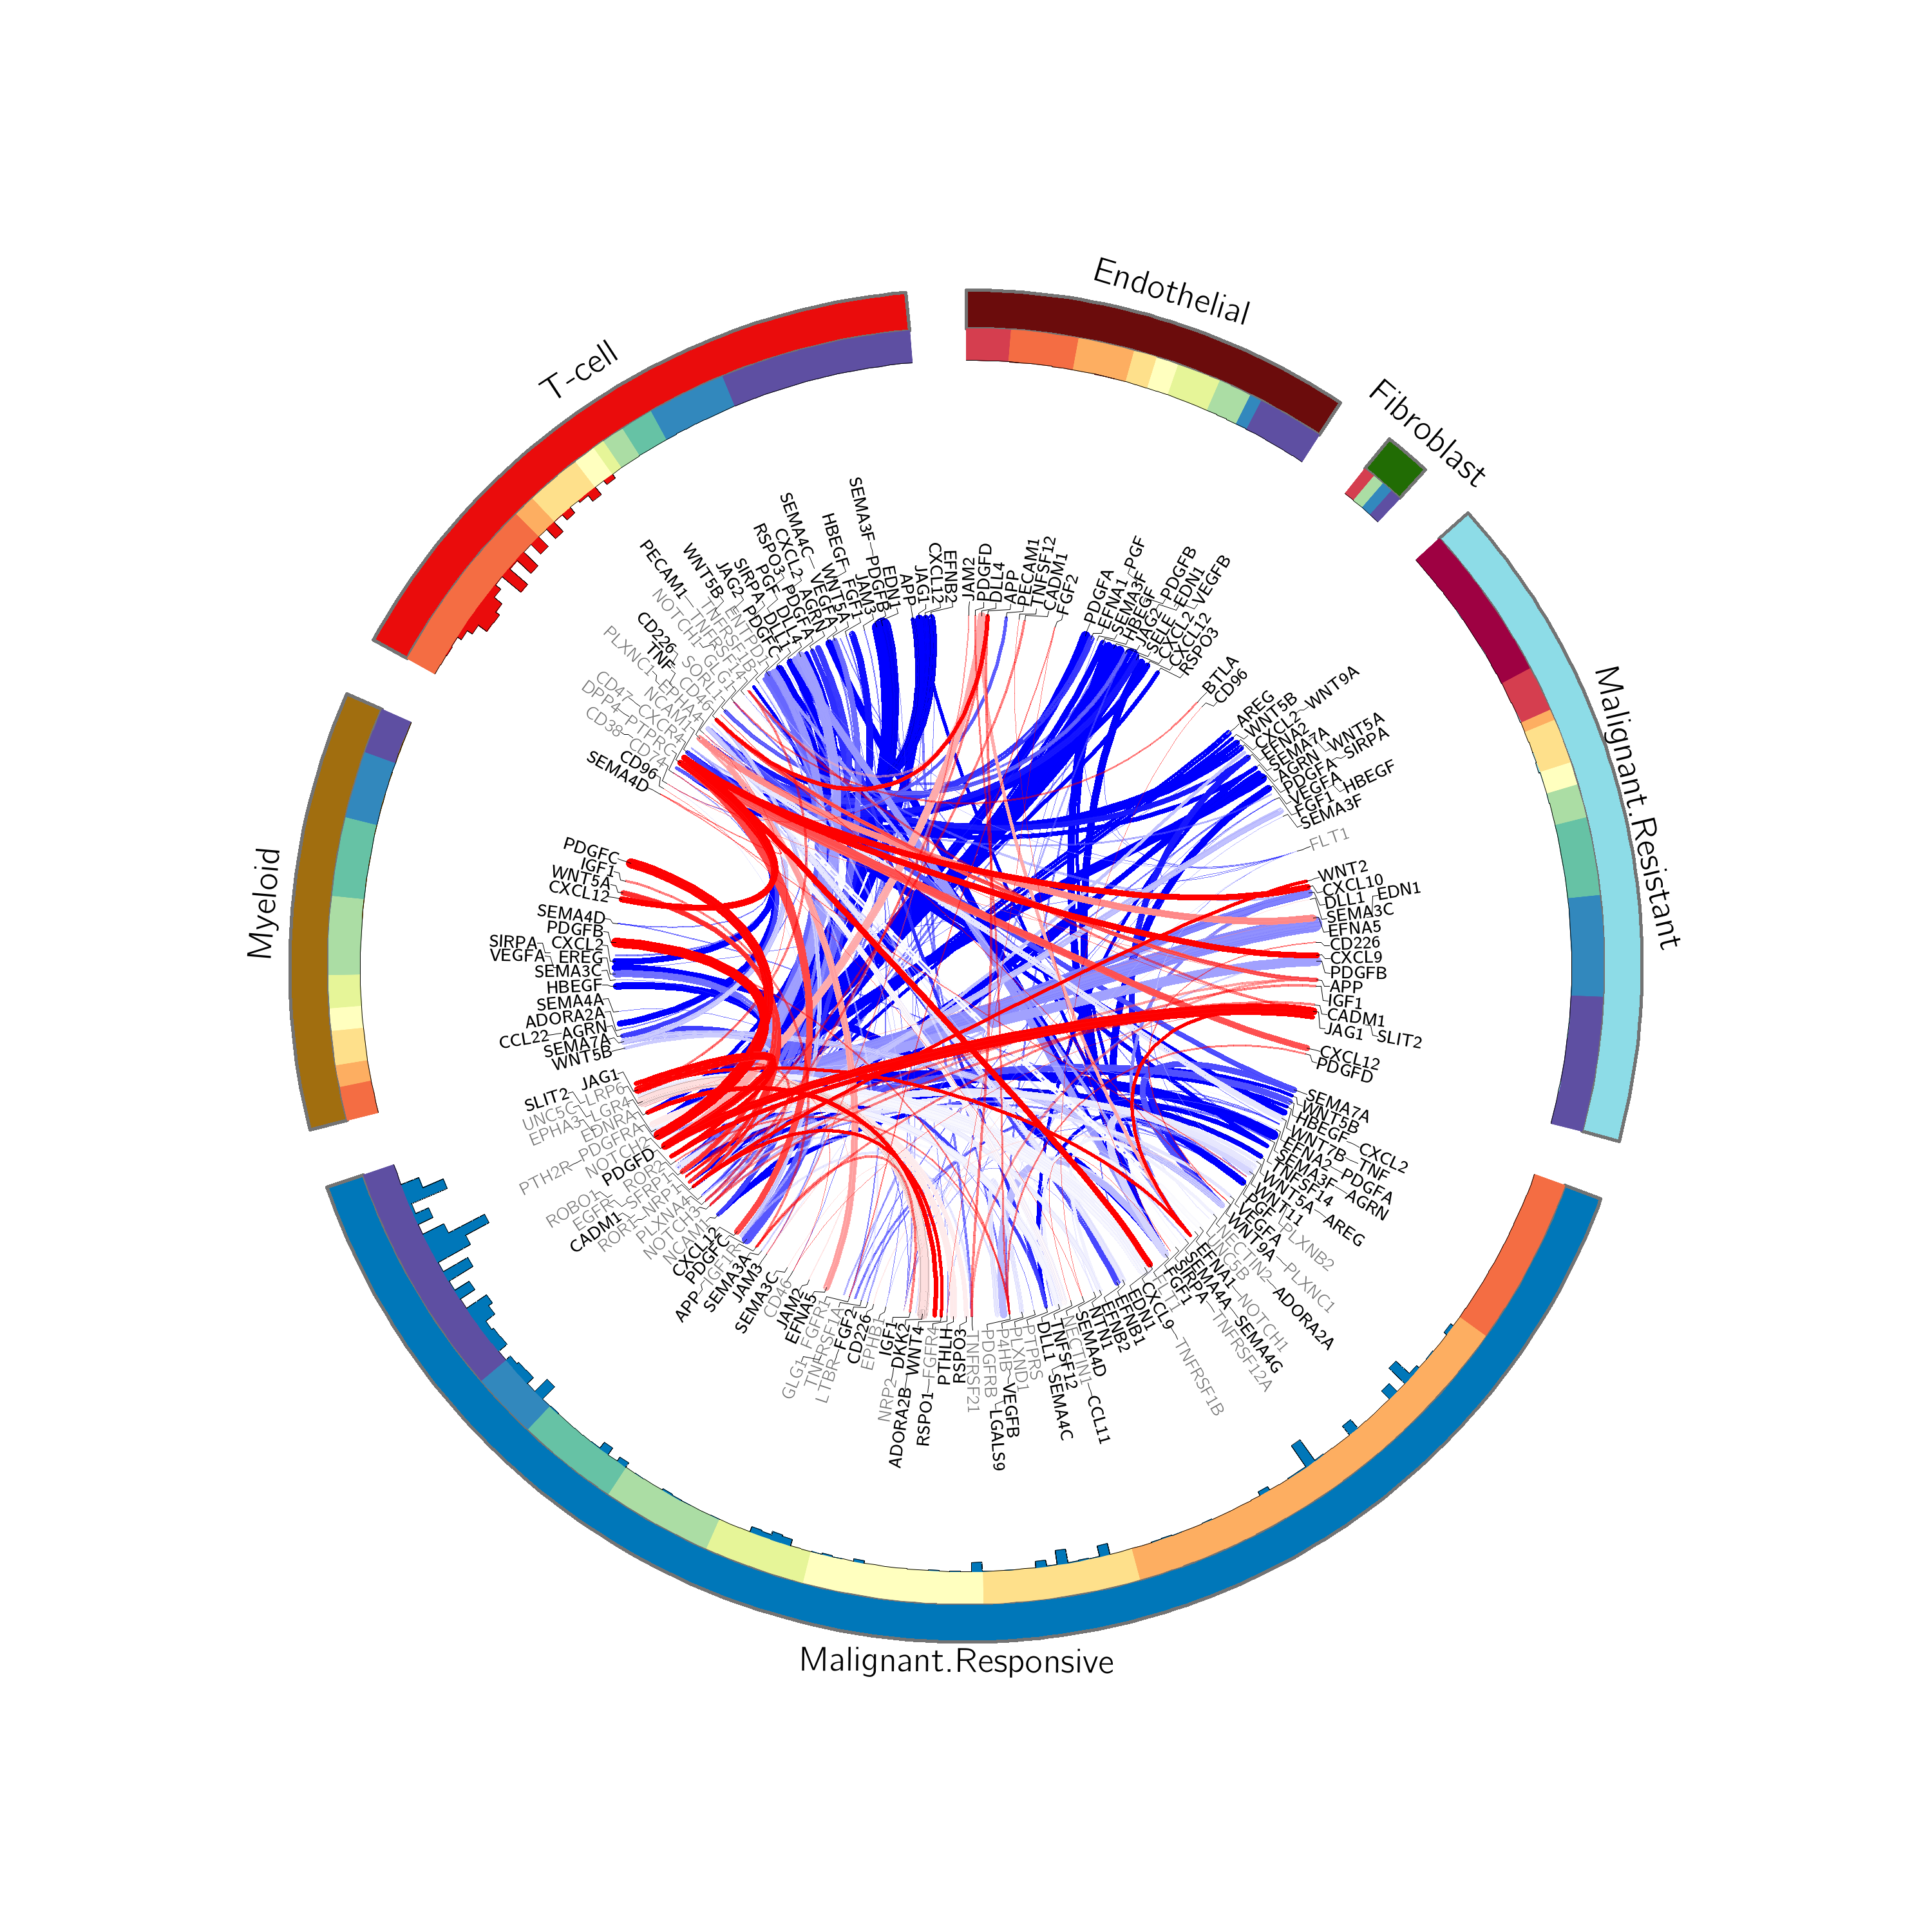

In [45]:
Image(f'{output_dir}/circos_all_2_filtered/circos.png')

In [122]:
target_stats.to_csv("sarcoma_target_strats.csv")

In [43]:
target_stats = pd.read_csv("sarcoma_target_strats.csv").set_index("Unnamed: 0")
set(target_stats['cell type'])

{'B-cell_Plasma_cell',
 'Endothelial_cell',
 'Fibroblast',
 'Malignant_resistant_clones',
 'Malignant_responsive_clones',
 'Myeloid',
 'T-cell'}

In [41]:
target_stats

,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr,type
Unnamed: 0,,,,,,,,,,,,,,
0,B cell,THBS1,0.114428,0.110343,-0.042751,0.139567,4287.7000,0.040778,0.0,False,True,-0.704831,7.559795e-03,ligand
1,Endothelial cell,ANXA1,0.449640,-0.152761,0.082233,-0.469861,2568.8726,0.024431,0.0,False,True,-0.182457,1.639741e-02,ligand
2,Endothelial cell,APP,0.823741,-0.206367,0.075416,-0.634744,10704.5880,0.101806,0.0,False,True,0.250264,3.102982e-09,ligand
3,Endothelial cell,CADM1,0.043165,-0.152062,-0.051889,-0.467712,5143.0273,0.048913,0.0,False,True,0.393479,5.866459e-03,ligand
4,Endothelial cell,COL4A1,0.989209,-0.125548,0.143646,-0.386161,14500.1870,0.137904,0.0,False,True,-0.119777,1.945633e-04,ligand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,T-cell,TNFRSF14,0.066429,-0.276972,-0.133317,-0.256529,1114.6589,0.010601,121.0,True,False,NaN,NaN,receptor
320,T-cell,TNFRSF1B,0.147687,-0.214098,-0.110322,-0.198295,1042.7139,0.009917,40.0,True,False,NaN,NaN,receptor
321,T-cell,VEGFA,0.004745,0.846250,-0.041025,0.783788,12860.2330,0.122307,0.0,False,True,-1.086748,2.808414e-06,ligand
